# EDA of the House Prices - Advanced Regression Competition

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set_context("talk", font_scale=1.2)
import plotly.express as px
import numpy as np

# I. Goals

* Predict the final price of home based on characteristic features of the house. This is a regression problem where we predict the actual house value.
* The whole population which could be the houses worldwide are not well represented in the dataset. Only *residential* homes in Ames, Iowa are included of the dataset.
* Performance Measure
    * Root-Mean-Squared-Error (RMSE) between the ***logarithm of the predicted value*** and the logarithm of the observed sales price. This allows for high and low prices to fairly equally contribute to the overall error.
    * metric Properties:
        * If prediction is 0 the log is undefined
        * Assymetric penalizatin: Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate. This is beneficial if I sell the house as I don't want at all cost to sell below the actual value as I would loose money. But if I want to buy the house the metric might not be the right choice
        * similar to the  Root Mean Squared Log Error (RMSLE) metric which contains additional value of 1 in prediction and ground truth to deal with 0 values
        * I aim to optimize RMSLE as it has desirable properties and is only slight variation from the pure log minus log approach
    

In [2]:
from sklearn.metrics import mean_squared_log_error

 Root Mean Squared Log Error (RMSLE) metric:

In [3]:
mean_squared_log_error?

In [4]:
def RMSLE(y_true:np.ndarray, y_pred:np.ndarray) -> np.float64:
    """
        The Root Mean Squared Log Error (RMSLE) metric 
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [5]:
import tensorflow as tf

In [6]:
def RMSLETF(y_pred:tf.Tensor, y_true:tf.Tensor) -> tf.float64:
    '''
        The Root Mean Squared Log Error (RMSLE) metric for TensorFlow / Keras
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Predicted values
        :return: The RMSLE score
    '''
    y_pred = tf.cast(y_pred, tf.float64)
    y_true = tf.cast(y_true, tf.float64) 
    y_pred = tf.nn.relu(y_pred) 
    return tf.sqrt(tf.reduce_mean(tf.squared_difference(tf.log1p(y_pred), tf.log1p(y_true))))

# II. Gather the Data

* The data is provided by kaggle and already split in train and validation. We do not know how this split was performed, maybe randomly or based on stratified sampling. Paper could give more info?
* The dataset is published in a paper: http://jse.amstat.org/v19n3/decock.pdf
* 



# III. Prepare the data


There are different types of missing values, depending on the definition. I count values as truly missing if they are not a valid categoryical variable (e.g. not having a pool).

In [7]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv",
                   keep_default_na=False, na_values=[""])
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv",
                  keep_default_na=False, na_values=[""])

Investigation the data description to understand the variables.

In [8]:
with open("../input/house-prices-advanced-regression-techniques/data_description.txt") as f:
    features = {}
    features_descr = {}
    for line in f.readlines():
        # feature name
        if line[0].isalnum():
            #print("feature")
            #print(line)
            feature_name = line.split(":")[0]
            feature_descr = line.split(":")[1]
            features[feature_name] = {}
            features_descr[feature_name] = feature_descr
        elif len(line.strip()) > 2:
            #print("feature val")
            #print("line: ", line, len(line))
            feature_vals = [val.strip() for val in line.split('\t')]
            #print(feature_vals)
            features[feature_name][feature_vals[0]] = feature_vals[1]
            #features[]
            
            
        

In [9]:
for feature in features_descr:
    print(f"############################# {feature}")
    print(features_descr[feature])
    print(features[feature])

############################# MSSubClass
 Identifies the type of dwelling involved in the sale.	

{'20': '1-STORY 1946 & NEWER ALL STYLES', '30': '1-STORY 1945 & OLDER', '40': '1-STORY W/FINISHED ATTIC ALL AGES', '45': '1-1/2 STORY - UNFINISHED ALL AGES', '50': '1-1/2 STORY FINISHED ALL AGES', '60': '2-STORY 1946 & NEWER', '70': '2-STORY 1945 & OLDER', '75': '2-1/2 STORY ALL AGES', '80': 'SPLIT OR MULTI-LEVEL', '85': 'SPLIT FOYER', '90': 'DUPLEX - ALL STYLES AND AGES', '120': '1-STORY PUD (Planned Unit Development) - 1946 & NEWER', '150': '1-1/2 STORY PUD - ALL AGES', '160': '2-STORY PUD - 1946 & NEWER', '180': 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', '190': '2 FAMILY CONVERSION - ALL STYLES AND AGES'}
############################# MSZoning
 Identifies the general zoning classification of the sale.

{'A': 'Agriculture', 'C': 'Commercial', 'FV': 'Floating Village Residential', 'I': 'Industrial', 'RH': 'Residential High Density', 'RL': 'Residential Low Density', 'RP': 'Residential Low 

# IV. Meet & Greet the data

* Train and test set have similar size.

Assumptions

* `id`: unique id
* 


In [10]:
print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [11]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [12]:
train.sample(10, random_state=42)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
892,893,20,RL,70,8414,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,6,8,1963,2003,Hip,CompShg,HdBoard,HdBoard,None,0,TA,TA,CBlock,TA,TA,No,GLQ,663,Unf,0,396,1059,GasA,TA,Y,SBrkr,1068,0,0,1068,0,1,1,0,3,1,TA,6,Typ,0,NA,Attchd,1963,RFn,1,264,TA,TA,Y,192,0,0,0,0,0,NA,MnPrv,NA,0,2,2006,WD,Normal,154500
1105,1106,60,RL,98,12256,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,1994,1995,Gable,CompShg,HdBoard,HdBoard,BrkFace,362,Gd,TA,PConc,Ex,TA,Av,GLQ,1032,Unf,0,431,1463,GasA,Ex,Y,SBrkr,1500,1122,0,2622,1,0,2,1,3,1,Gd,9,Typ,2,TA,Attchd,1994,RFn,2,712,TA,TA,Y,186,32,0,0,0,0,NA,NA,NA,0,4,2010,WD,Normal,325000
413,414,30,RM,56,8960,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,5,6,1927,1950,Gable,CompShg,WdShing,Wd Shng,None,0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1008,1008,GasA,Gd,Y,FuseA,1028,0,0,1028,0,0,1,0,2,1,TA,5,Typ,1,Gd,Detchd,1927,Unf,2,360,TA,TA,Y,0,0,130,0,0,0,NA,NA,NA,0,3,2010,WD,Normal,115000
522,523,50,RM,50,5000,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Feedr,Norm,1Fam,1.5Fin,6,7,1947,1950,Gable,CompShg,CemntBd,CmentBd,None,0,TA,Gd,CBlock,TA,TA,No,ALQ,399,Unf,0,605,1004,GasA,Ex,Y,SBrkr,1004,660,0,1664,0,0,2,0,3,1,TA,7,Typ,2,Gd,Detchd,1950,Unf,2,420,TA,TA,Y,0,24,36,0,0,0,NA,NA,NA,0,10,2006,WD,Normal,159000
1036,1037,20,RL,89,12898,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,2007,2008,Hip,CompShg,VinylSd,VinylSd,Stone,70,Gd,TA,PConc,Ex,TA,Gd,GLQ,1022,Unf,0,598,1620,GasA,Ex,Y,SBrkr,1620,0,0,1620,1,0,2,0,2,1,Ex,6,Typ,1,Ex,Attchd,2008,Fin,3,912,TA,TA,Y,228,0,0,0,0,0,NA,NA,NA,0,9,2009,WD,Normal,315500
614,615,180,RM,21,1491,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,SFoyer,4,6,1972,1972,Gable,CompShg,CemntBd,CmentBd,None,0,TA,TA,CBlock,Gd,TA,Av,LwQ,150,GLQ,480,0,630,GasA,Ex,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,TA,3,Typ,0,NA,NA,NA,NA,0,0,NA,NA,Y,96,24,0,0,0,0,NA,NA,NA,0,5,2010,WD,Normal,75500
218,219,50,RL,NA,15660,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,7,9,1939,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,312,Gd,Gd,CBlock,TA,TA,No,BLQ,341,Unf,0,457,798,GasA,Ex,Y,SBrkr,1137,817,0,1954,0,1,1,1,3,1,Gd,8,Typ,2,TA,Attchd,1939,Unf,2,431,TA,TA,Y,0,119,150,0,0,0,NA,NA,NA,0,5,2008,WD,Normal,311500
1160,1161,160,RL,24,2280,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NPkVill,Norm,Norm,Twnhs,2Story,6,5,1978,1978,Gable,CompShg,Plywood,Brk Cmn,None,0,TA,TA,CBlock,Gd,TA,No,ALQ,311,Unf,0,544,855,GasA,Fa,Y,SBrkr,855,601,0,1456,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1978,Unf,2,440,TA,TA,Y,26,0,0,0,0,0,NA,NA,NA,0,7,2010,WD,Normal,146000
649,650,180,RM,21,1936,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,4,6,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0,TA,TA,CBlock,Gd,TA,Av,BLQ,131,GLQ,499,0,630,GasA,Gd,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,TA,3,Typ,0,NA,NA,NA,NA,0,0,NA,NA,Y,0,0,0,0,0,0,NA,MnPrv,NA,0,12,2007,WD,Normal,84500
887,888,50,RL,59,16466,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,5,7,1955,1955,Gable,CompShg,MetalSd,MetalSd,None,0,TA,Gd,PConc,TA,TA,No,Unf,0,Unf,0,816,816,GasA,TA,Y,SBrkr,872,521,0,1393,0,0,1,1,3,1,TA,8,Typ,0,NA,Attchd,1955,Unf,1,300,TA,TA,Y,121,0,0,0,2

## Data Types

Assure that features are correctly represented by types.

* LotArea: in int but could be float instead
* YearBuilt, YearRemodAdd: in int but could use potentially other dtype, datetime, or age?
* BsmtFinSF2, BsmtUnfSF, TotalBsmtSF all in int but are quare feet so non-int are valid.

Could be improved

1stFlrSF int64 []
2ndFlrSF int64 []
LowQualFinSF int64 []
GrLivArea int64 []


In [13]:
num_cols = ['SalePrice', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd','MasVnrArea', 'BsmtFinSF1',
               'BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
               'LowQualFinSF', 'GrLivArea', 
               'BsmtFullBath', 'BsmtHalfBath', 'FullBath', # check the values, expect discrete numeric
               'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
               'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
               'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
               'MiscVal', 'MoSold', 'YrSold', 'OverallCond', 'OverallQual']


cat_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
               'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
               'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
               'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 
                'PoolQC', 'Fence', 'SaleType', 'SaleCondition', 'MiscFeature']

> data description file inconsistency in naming: Bedroom == 

In [14]:
ordinal_cat = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                  'BsmtExposure', # could be treated as ordinal except maybe one category
                  'BsmtFinType1',
                  'BsmtFinType2', # likely good choice of ordernal
                  'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
                  'GarageFinish', 'GarageQual', 'GarageCond',
                  'PoolQC',
                  'Fence', # except no fence which does not fit in the order
                  ] #

In [15]:
mapping_features = {"ExterQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
                       "ExterCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
                       "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                        "BsmtCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                        "BsmtExposure": {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
                        "BsmtFinType1": {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
                        "BsmtFinType2" : {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
                        "HeatingQC": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
                        "KitchenQual" :  {"Po": 0, "Fa": 1, "TA": "2", "Gd": 3, "Ex": 4},
                        "Functional": {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7},
                        "FireplaceQu": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                        "GarageFinish": {"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3},
                        "GarageQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                        "GarageCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                        "PoolQC": {"NA": 0, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                        "Fence": {"NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv":3 , "GdPrv":4}}

Ensure no features are missed

In [16]:
num_cols_num = 0
cat_cols_num = 0

for feat in features.keys():
    if feat in num_cols:
        num_cols_num += 1
    elif feat in cat_cols:
        cat_cols_num +=1
    else:
        print(f"feature {feat} missed")
print(f" {len(num_cols)}, {num_cols_num}")
print(f" {len(cat_cols)}, {cat_cols_num}")

feature Bedroom missed
feature Kitchen missed
 36, 33
 44, 44


Ok, as names differ.

In [17]:
train[num_cols].dtypes

SalePrice         int64
LotFrontage      object
LotArea           int64
YearBuilt         int64
YearRemodAdd      int64
MasVnrArea       object
BsmtFinSF1        int64
BsmtFinSF2        int64
BsmtUnfSF         int64
TotalBsmtSF       int64
1stFlrSF          int64
2ndFlrSF          int64
LowQualFinSF      int64
GrLivArea         int64
BsmtFullBath      int64
BsmtHalfBath      int64
FullBath          int64
HalfBath          int64
BedroomAbvGr      int64
KitchenAbvGr      int64
TotRmsAbvGrd      int64
Fireplaces        int64
GarageYrBlt      object
GarageCars        int64
GarageArea        int64
WoodDeckSF        int64
OpenPorchSF       int64
EnclosedPorch     int64
3SsnPorch         int64
ScreenPorch       int64
PoolArea          int64
MiscVal           int64
MoSold            int64
YrSold            int64
OverallCond       int64
OverallQual       int64
dtype: object

all 3 features below do not have as a valid value NA, hence treat as truely missing.

In [18]:
train['LotFrontage'].value_counts().head()

NA    259
60    143
70     70
80     69
50     57
Name: LotFrontage, dtype: int64

In [19]:
train['LotFrontage'] = train['LotFrontage'].replace("NA", np.nan).astype(float)

In [20]:
train['MasVnrArea'].value_counts().head()

0      861
NA       8
72       8
108      8
180      8
Name: MasVnrArea, dtype: int64

In [21]:
train['MasVnrArea'] = train['MasVnrArea'].replace("NA", np.nan).astype(float)

In [22]:
train['GarageYrBlt'].value_counts().head()

NA      81
2005    65
2006    59
2004    53
2003    50
Name: GarageYrBlt, dtype: int64

In [23]:
train['GarageYrBlt'] = train['GarageYrBlt'].replace("NA", np.nan).astype(float)

In [24]:
train[num_cols].dtypes.value_counts()

int64      33
float64     3
dtype: int64

Now all numeric columns have numeric data types.

In [25]:
train[cat_cols].dtypes

MSSubClass        int64
MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
SaleType        

In [26]:
train['MSSubClass'] = train['MSSubClass'].astype(str)

Also agreement, after correction, all object type.

In [27]:
for feat in features.keys():
    print(feat)
    #print(feat, train.dtypes.to_dict()[feat], list(features[feat].keys()))
    print(feat, list(features[feat].keys()))
    

MSSubClass
MSSubClass ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190']
MSZoning
MSZoning ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM']
LotFrontage
LotFrontage []
LotArea
LotArea []
Street
Street ['Grvl', 'Pave']
Alley
Alley ['Grvl', 'Pave', 'NA']
LotShape
LotShape ['Reg', 'IR1', 'IR2', 'IR3']
LandContour
LandContour ['Lvl', 'Bnk', 'HLS', 'Low']
Utilities
Utilities ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']
LotConfig
LotConfig ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3']
LandSlope
LandSlope ['Gtl', 'Mod', 'Sev']
Neighborhood
Neighborhood ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
Condition1
Condition1 ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe']
Condition2
Condition2 ['Artery', 'Feedr', '

### Zero-Variance Features?

No zero-variance features which would be worth dropping.

In [28]:
train.nunique().sort_values()

CentralAir       2
Street           2
Utilities        2
PavedDrive       3
Alley            3
              ... 
1stFlrSF       753
BsmtUnfSF      780
GrLivArea      861
LotArea       1073
Id            1460
Length: 81, dtype: int64

## Missingness

Are there indications that missigness is encoded in a different way and not recognized by pandas as missing?
earlier inspection did not indicate that.

* `Alley`, `PoolQC`, `Fence` are categorical variables which have NA as valid category, no missingnesss!
* `BsmtQual` has valid cateogry NA. There are one or two other variables. with thte same characteristic.

> All truely missing values where identified through pandas nan.


In [29]:
import missingno as msno

In [30]:
train.isna().sum().sort_values(ascending=False).head(20)

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
Id                0
KitchenAbvGr      0
GarageType        0
FireplaceQu       0
Fireplaces        0
Functional        0
TotRmsAbvGrd      0
KitchenQual       0
BedroomAbvGr      0
GarageCars        0
HalfBath          0
FullBath          0
BsmtHalfBath      0
BsmtFullBath      0
GrLivArea         0
LowQualFinSF      0
2ndFlrSF          0
dtype: int64

In [31]:
train.isna().sum().sort_values(ascending=False).div(train.shape[0]).head(20)

LotFrontage     0.177397
GarageYrBlt     0.055479
MasVnrArea      0.005479
Id              0.000000
KitchenAbvGr    0.000000
GarageType      0.000000
FireplaceQu     0.000000
Fireplaces      0.000000
Functional      0.000000
TotRmsAbvGrd    0.000000
KitchenQual     0.000000
BedroomAbvGr    0.000000
GarageCars      0.000000
HalfBath        0.000000
FullBath        0.000000
BsmtHalfBath    0.000000
BsmtFullBath    0.000000
GrLivArea       0.000000
LowQualFinSF    0.000000
2ndFlrSF        0.000000
dtype: float64

> 

> 3 features have high missigness as detected through empty string "".

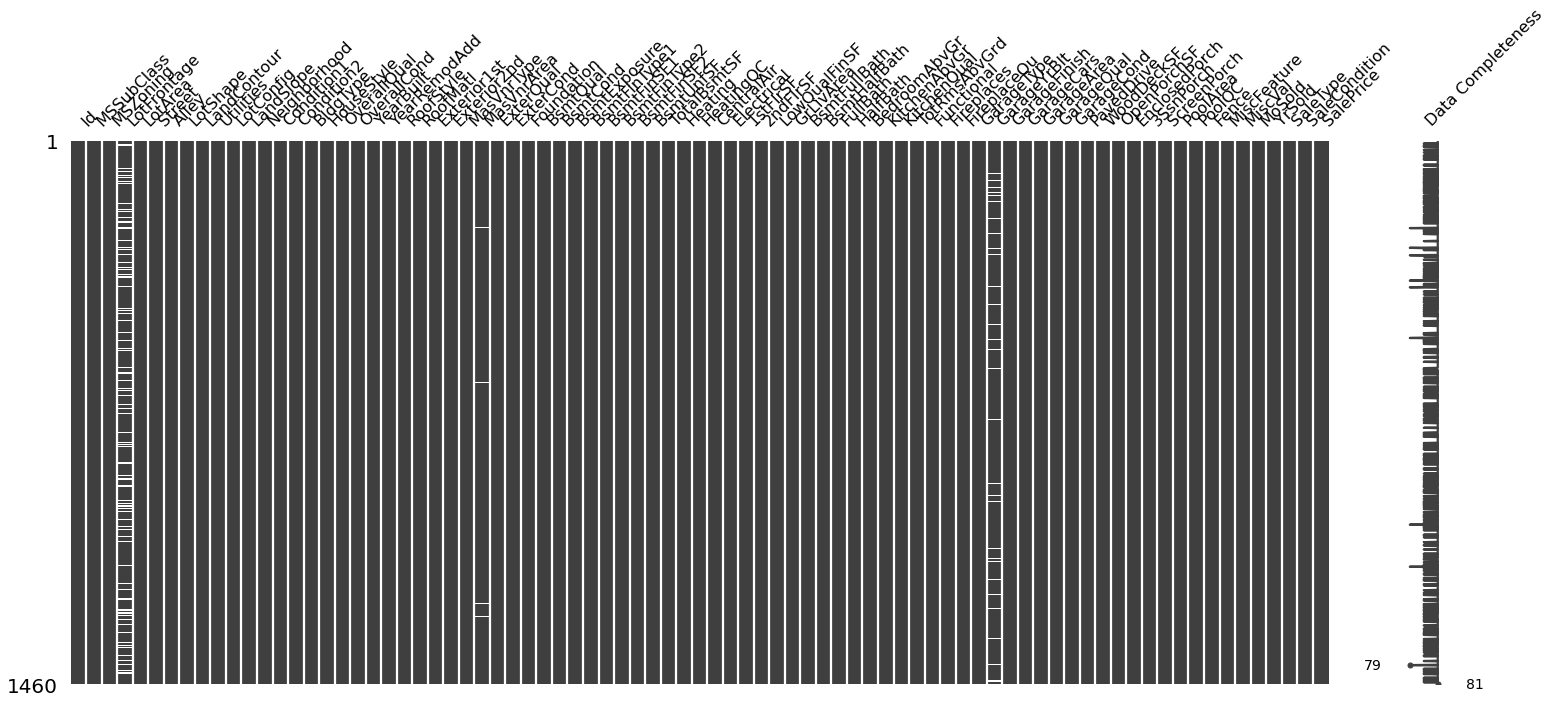

In [32]:
with sns.plotting_context("talk", font_scale=0.4):
    msno.matrix(train, labels=True)

> There is clear structure in missingness. Some variables have missingness correlated.

## Duplicates

No duplicate rows.

In [33]:
train.duplicated().sum()

0

# V. Univariate Analysis

* id: simple identifier



In [34]:
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.00,163000.0,214000.00,755000.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0


* `salesprice` spans wide range.
* `LotArea` differs greatly in range, skewed with very high values
* Most recent year `2010` build, indicate time creation of dataset. Extremely old house with year `1872`
* houses sold between year 2007 and 2010. narrow range.
* OverallCond and OverallQual include all values available. So large variaty of houses leading to different house prices.

In [35]:
train[cat_cols].describe()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,SaleType,SaleCondition,MiscFeature
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,15,5,2,3,4,4,2,5,3,25,9,8,5,8,6,8,15,16,5,4,5,6,5,5,5,7,7,6,5,2,6,4,7,6,7,4,6,6,3,4,5,9,6,5
top,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NA,Attchd,Unf,TA,TA,Y,NA,NA,WD,Normal,NA
freq,536,1151,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,690,870,605,1311,1326,1340,1453,1179,1267,1198,1406


* some variables have a dominant category, and hence might not be useful:
    * `Street` not very useful, only 6 values are not belong to the major category
    * `Utilities` also not useful, due to almost all one category. Drop from analysis
    * `Condition2` maybe drop due to main category. 15 datapoints of other category.
    * `RoofMatl` similarly, only 26 data points from other category, not main

* 

### id


In [36]:
train['Id'].nunique()

1460

### Numerical Feature Distributions

SalePrice


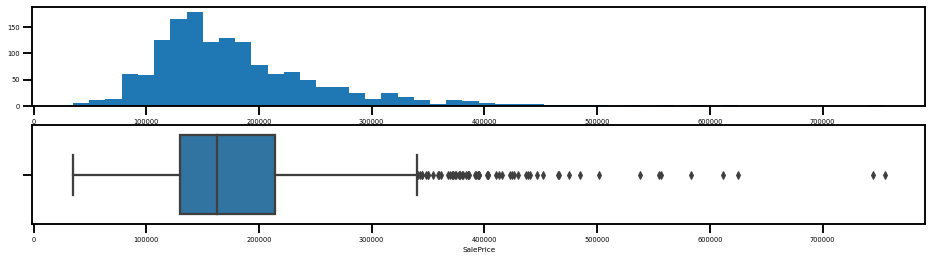

LotFrontage


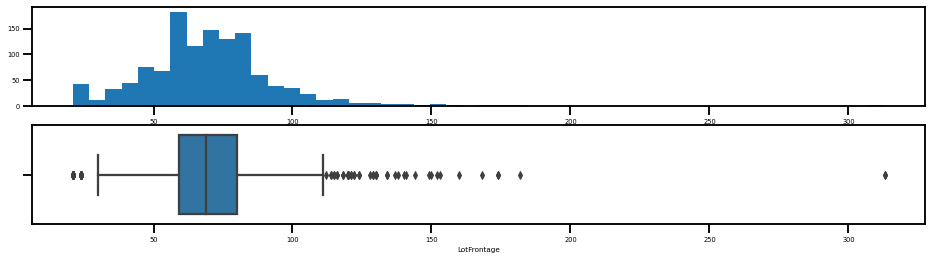

LotArea


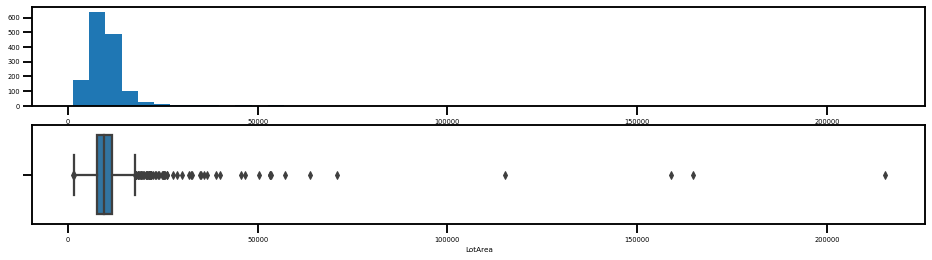

YearBuilt


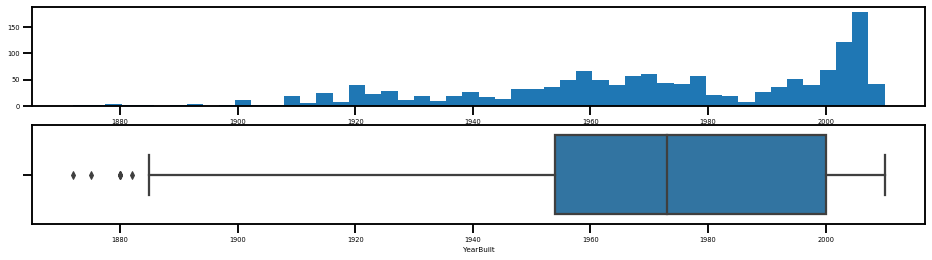

YearRemodAdd


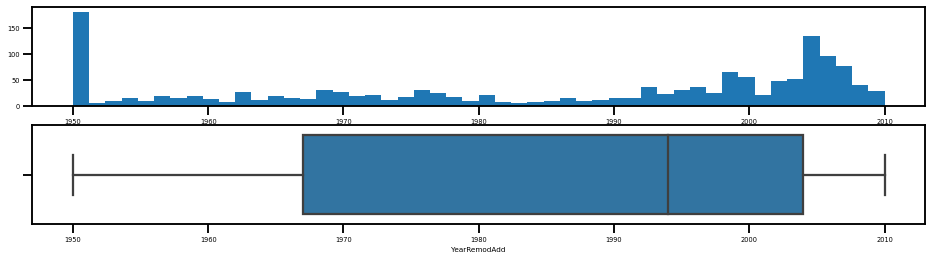

MasVnrArea


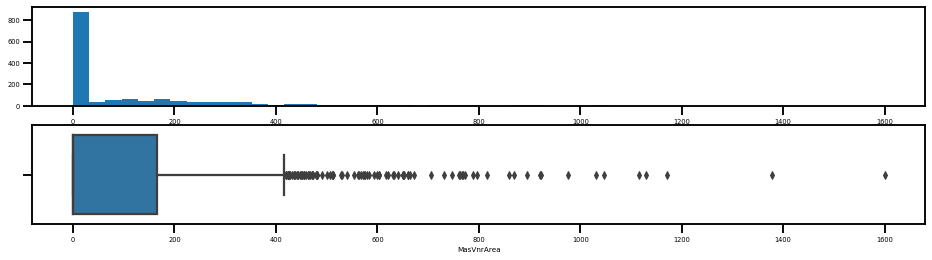

BsmtFinSF1


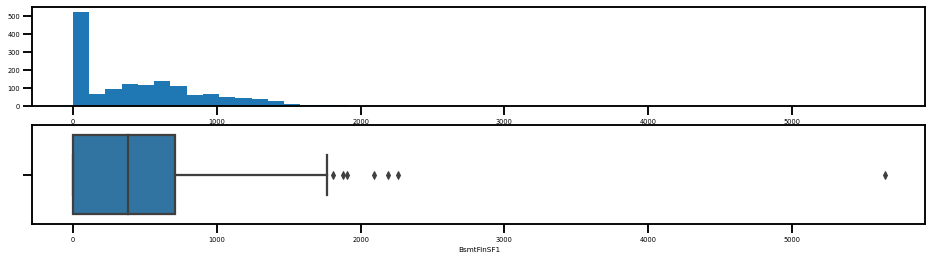

BsmtFinSF2


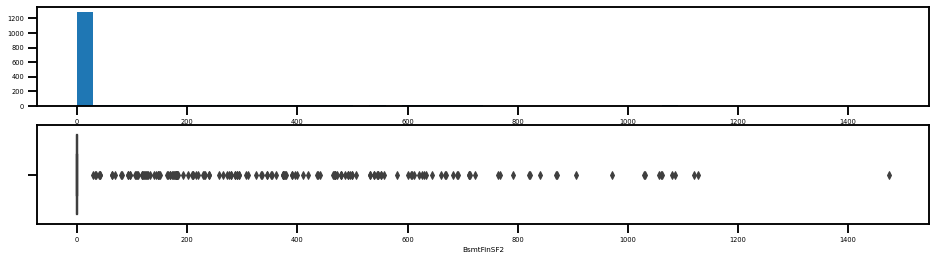

BsmtUnfSF


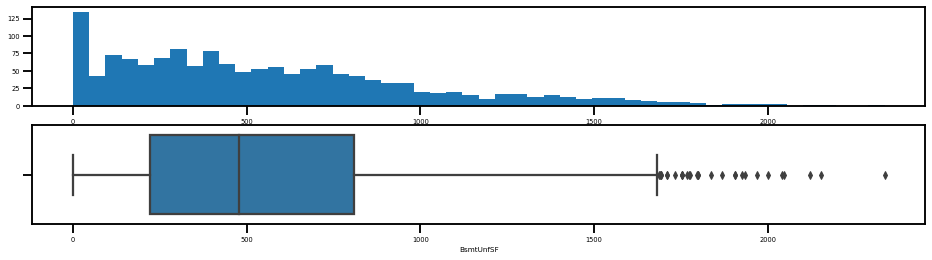

TotalBsmtSF


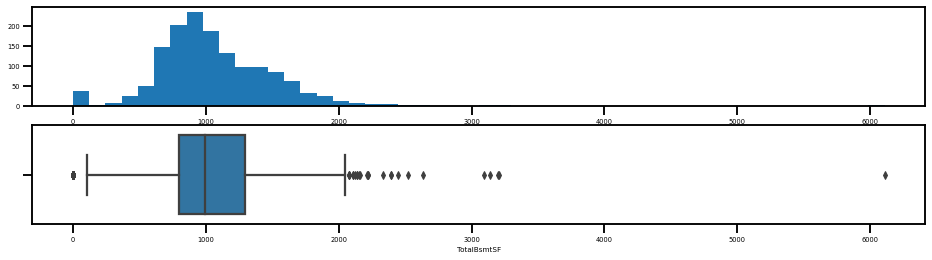

1stFlrSF


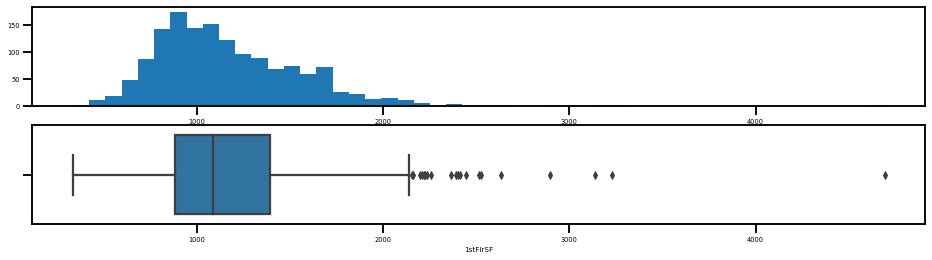

2ndFlrSF


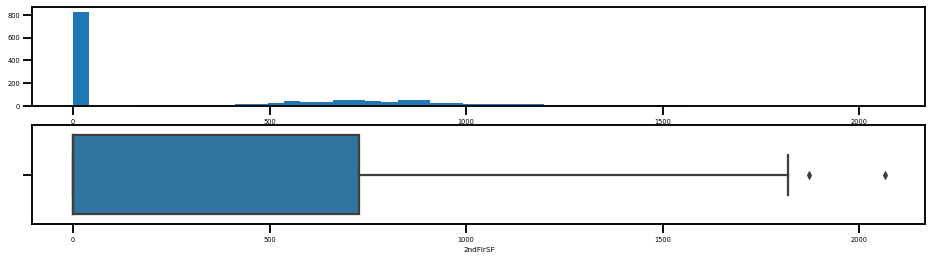

LowQualFinSF


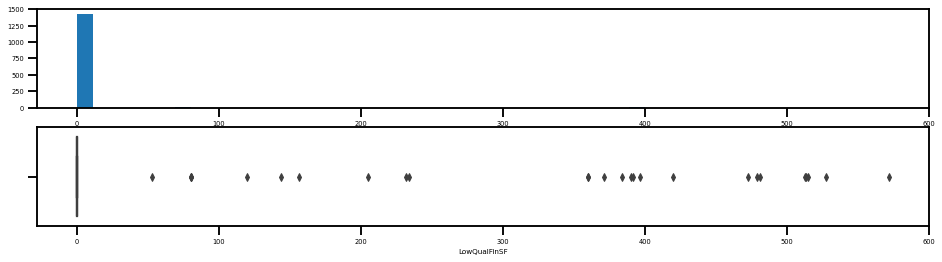

GrLivArea


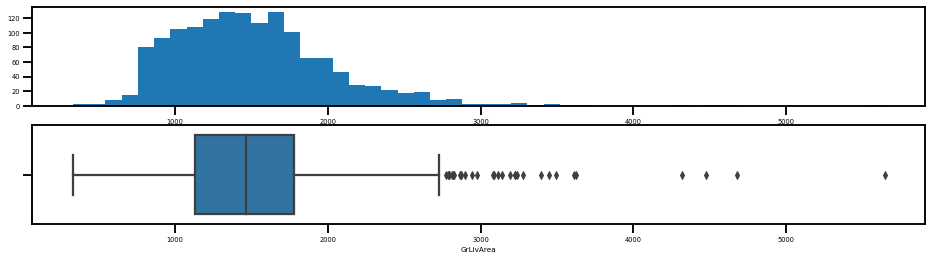

BsmtFullBath


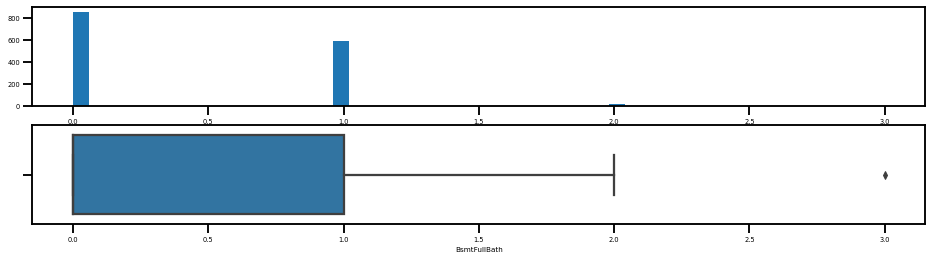

BsmtHalfBath


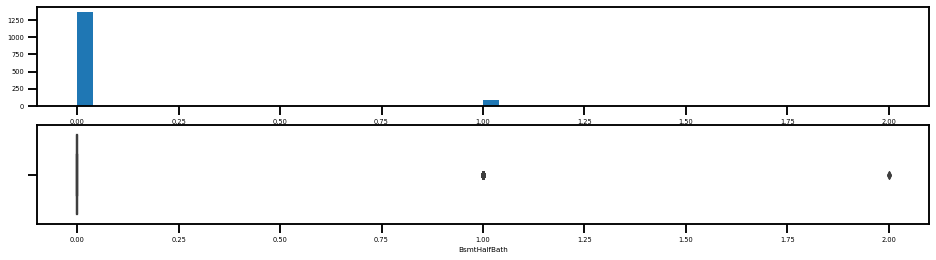

FullBath


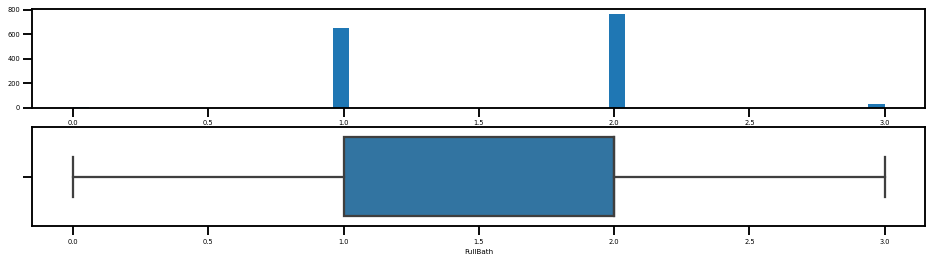

HalfBath


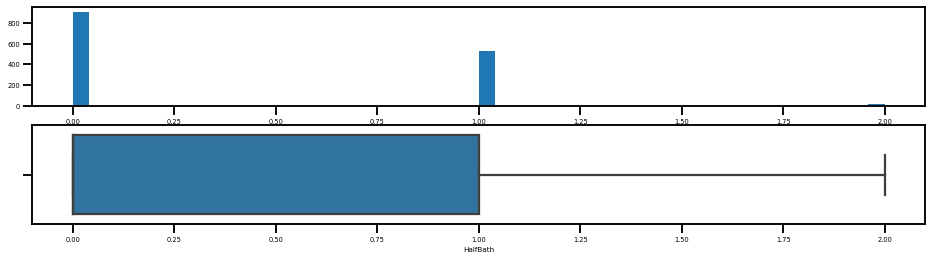

BedroomAbvGr


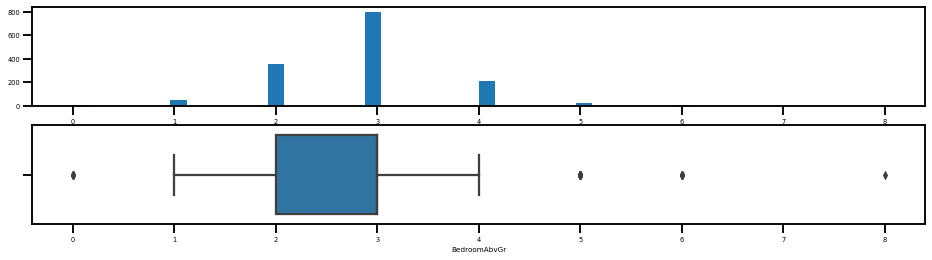

KitchenAbvGr


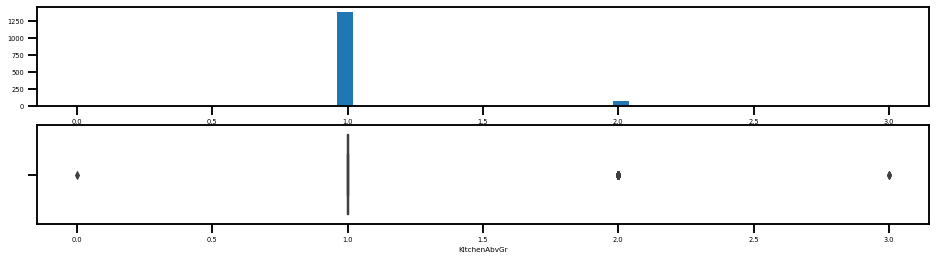

TotRmsAbvGrd


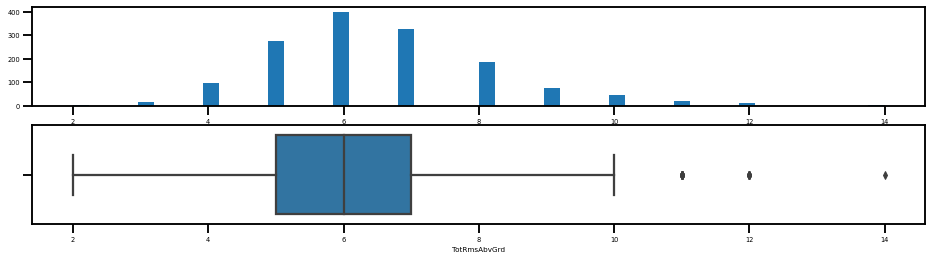

Fireplaces


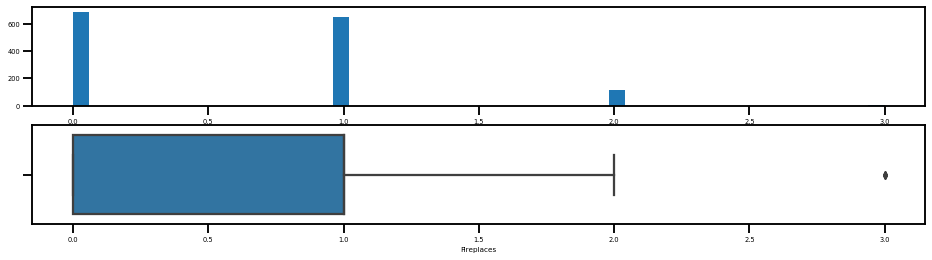

GarageYrBlt


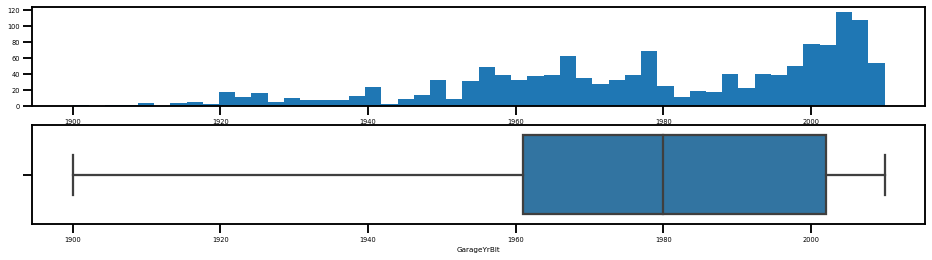

GarageCars


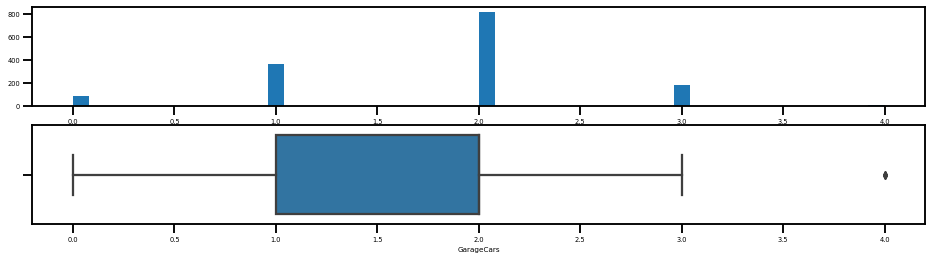

GarageArea


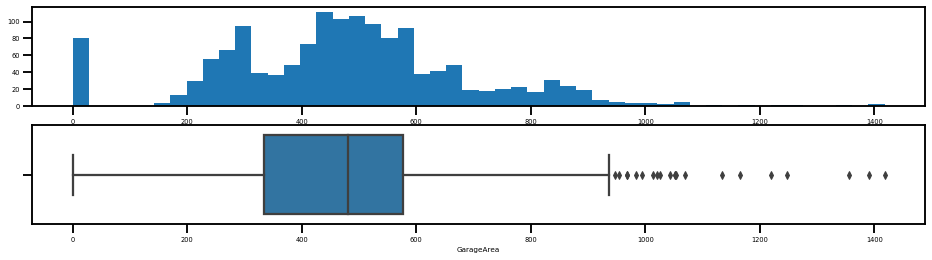

WoodDeckSF


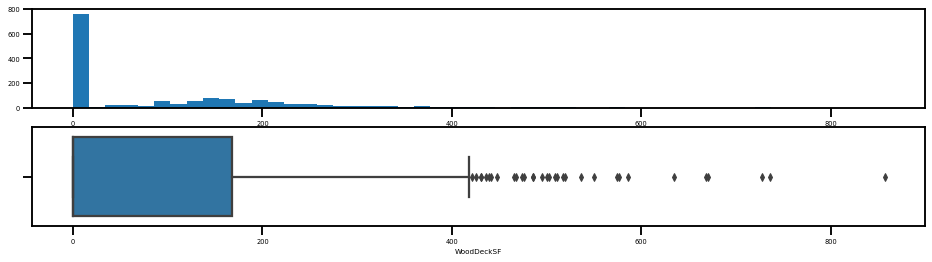

OpenPorchSF


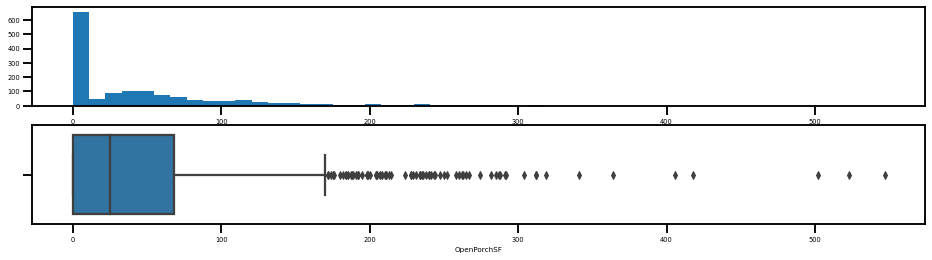

EnclosedPorch


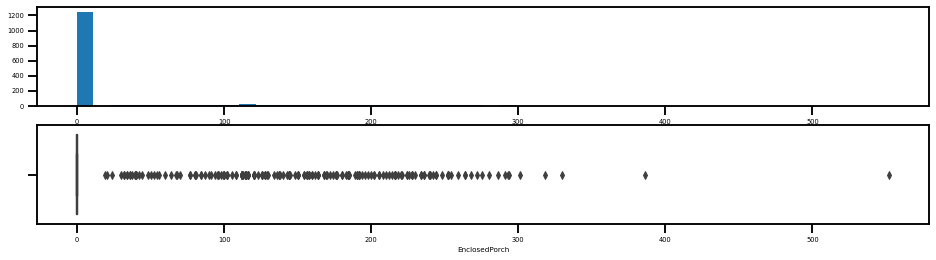

3SsnPorch


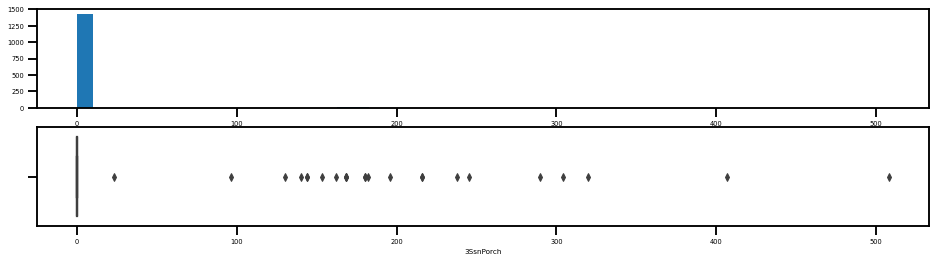

ScreenPorch


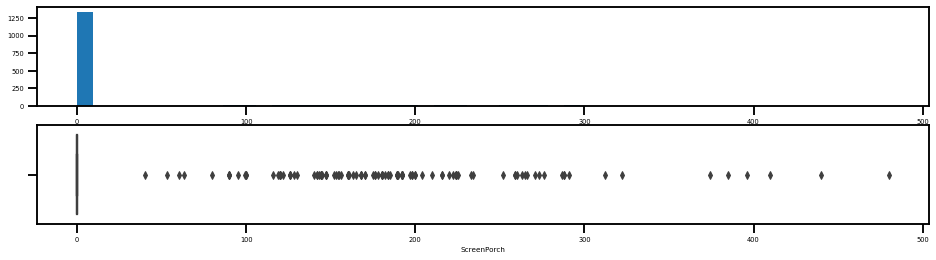

PoolArea


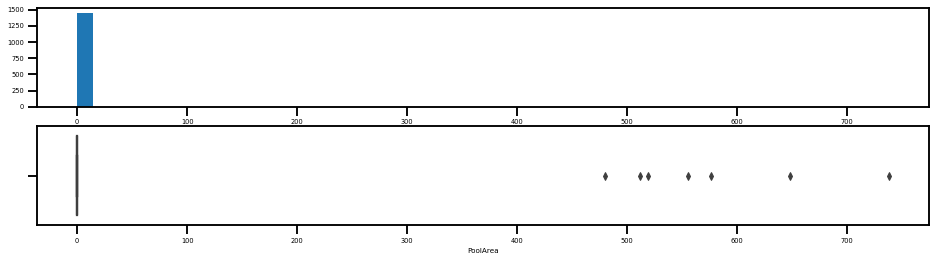

MiscVal


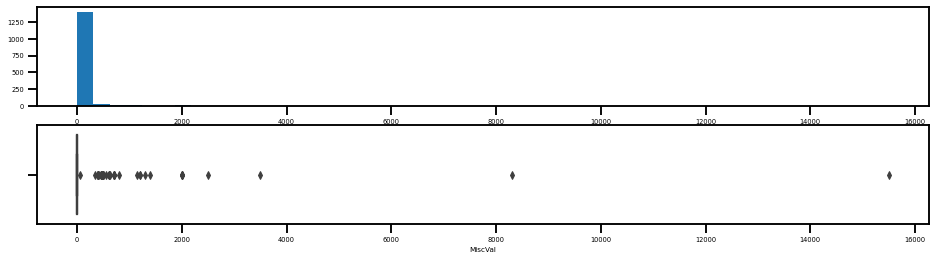

MoSold


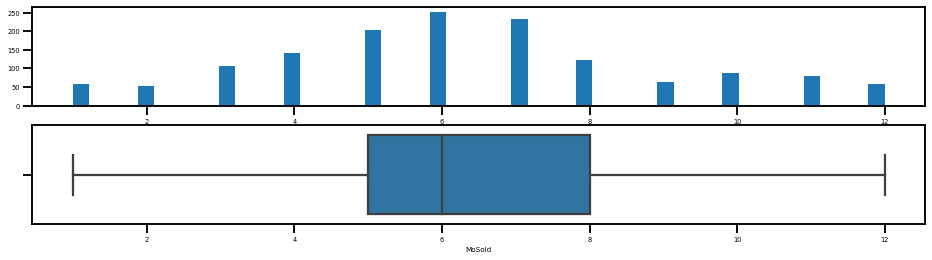

YrSold


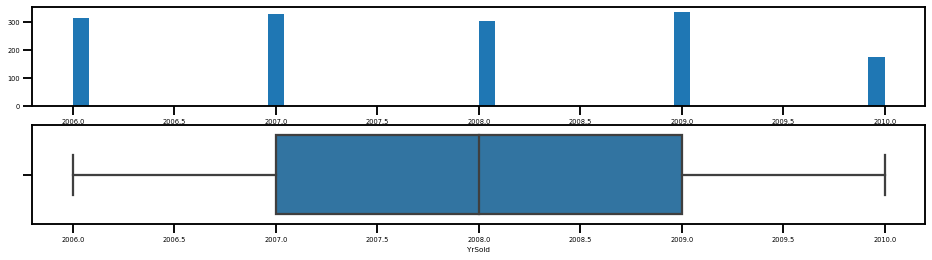

OverallCond


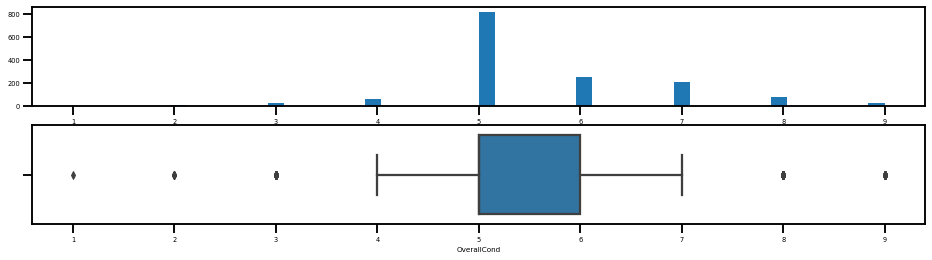

OverallQual


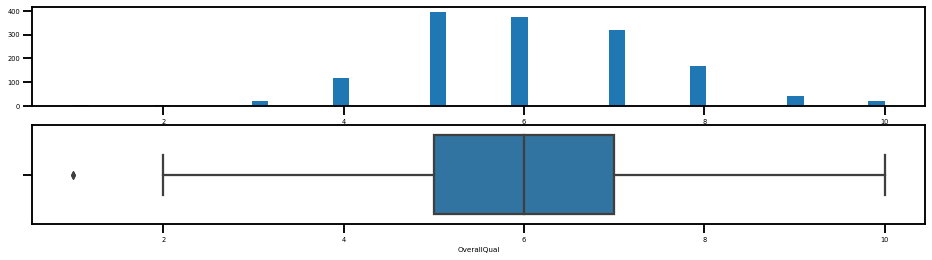

In [37]:
for i, col in enumerate(num_cols):
    print(col)
    with sns.plotting_context("talk", font_scale=0.4):
        fig, axes = plt.subplots(2,1, figsize=(16,4)) # create figure and axes
        train[col].hist(bins=50, grid=False, ax=axes[0])
        sns.boxplot(x=train[col], ax=axes[1])
        plt.show()

> Sales price target variable is highly skewed to the right. Log transformation could be an option or winzorisation.

* Some features might be benefitial to transform similarlity, such as the SF features.

In [38]:
for col in cat_cols:
    print("#"*20, col, "#"*20)
    print(pd.merge(train[col].value_counts(dropna=False), train[col].value_counts(dropna=False, normalize=True), 
                   left_index=True, right_index=True))

#################### MSSubClass ####################
     MSSubClass_x  MSSubClass_y
20            536      0.367123
60            299      0.204795
50            144      0.098630
120            87      0.059589
30             69      0.047260
160            63      0.043151
70             60      0.041096
80             58      0.039726
90             52      0.035616
190            30      0.020548
85             20      0.013699
75             16      0.010959
45             12      0.008219
180            10      0.006849
40              4      0.002740
#################### MSZoning ####################
         MSZoning_x  MSZoning_y
RL             1151    0.788356
RM              218    0.149315
FV               65    0.044521
RH               16    0.010959
C (all)          10    0.006849
#################### Street ####################
      Street_x  Street_y
Pave      1454   0.99589
Grvl         6   0.00411
#################### Alley ####################
      Alley_x   Alle

# IV. Multivariate Analysis

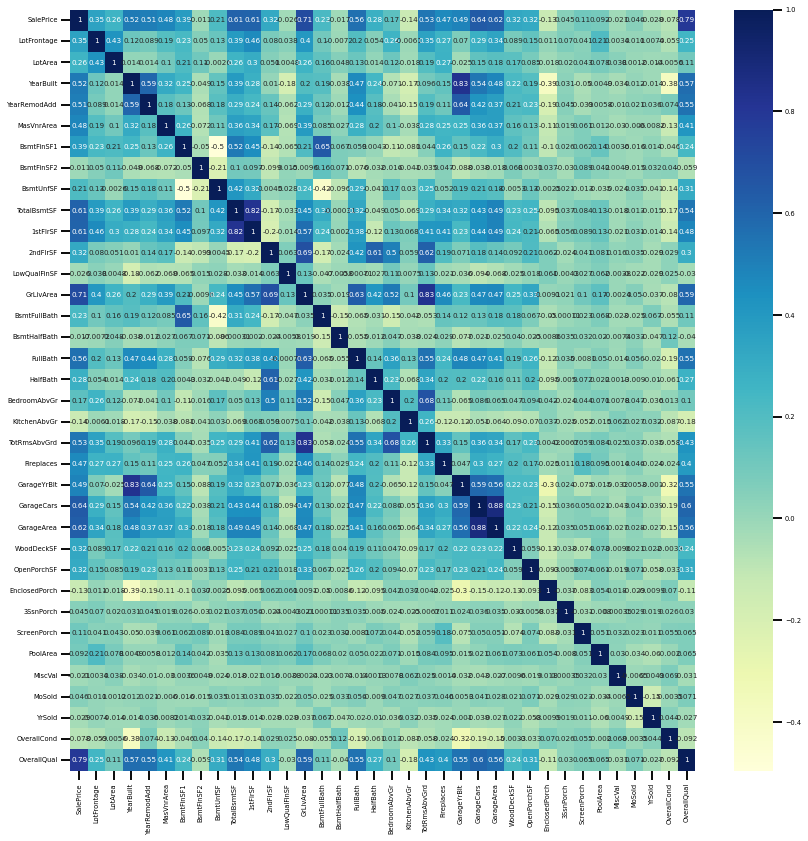

In [39]:
with sns.plotting_context("talk", font_scale=0.4):
    plt.figure(figsize=(14,14))
    sns.heatmap(train[num_cols].corr(), annot = True, cmap="YlGnBu")

In [40]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train[num_cols], 5))

Top Absolute Correlations
GarageCars   GarageArea      0.882475
YearBuilt    GarageYrBlt     0.825667
GrLivArea    TotRmsAbvGrd    0.825489
TotalBsmtSF  1stFlrSF        0.819530
SalePrice    OverallQual     0.790982
dtype: float64


> Significant correlation between some variables, e.g. garage cars and garage areas as expected. Could drop later.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


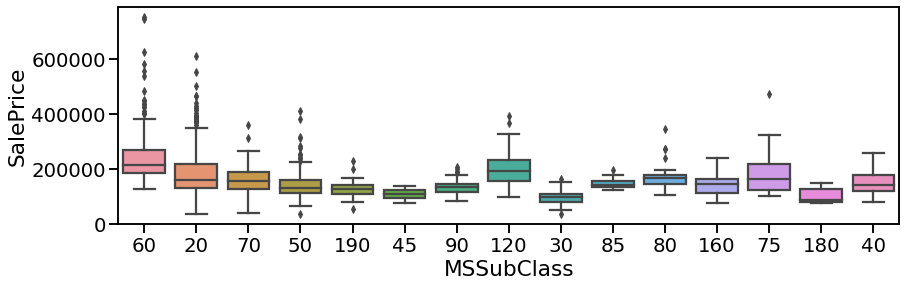

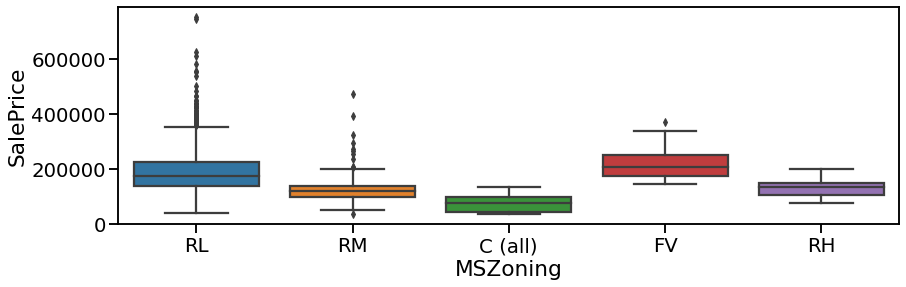

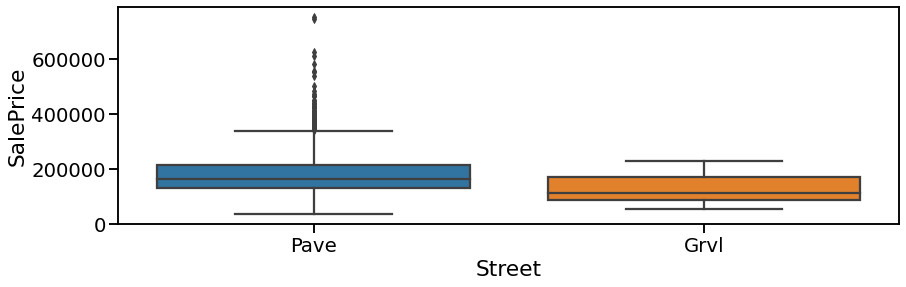

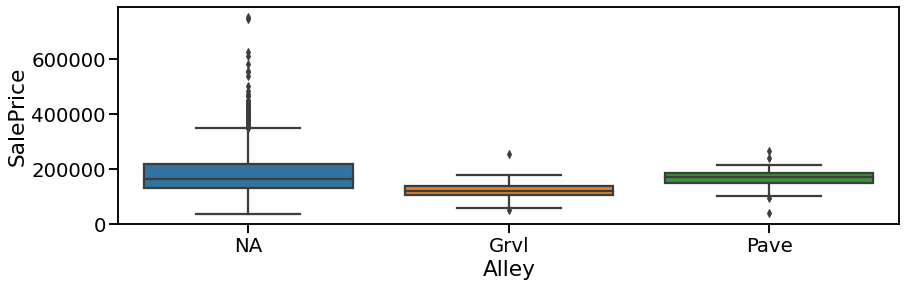

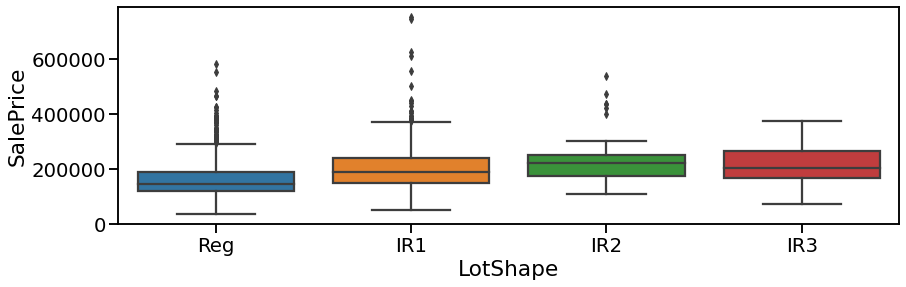

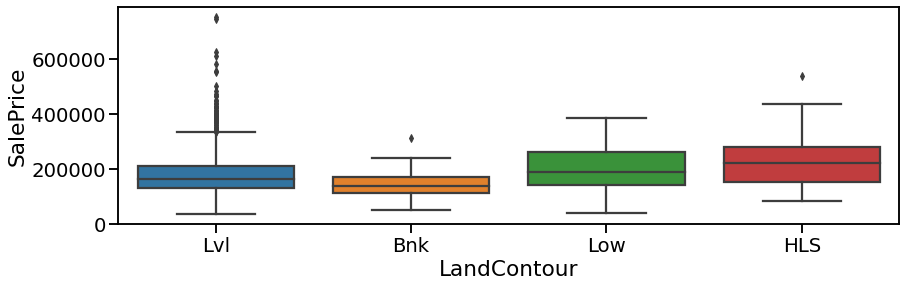

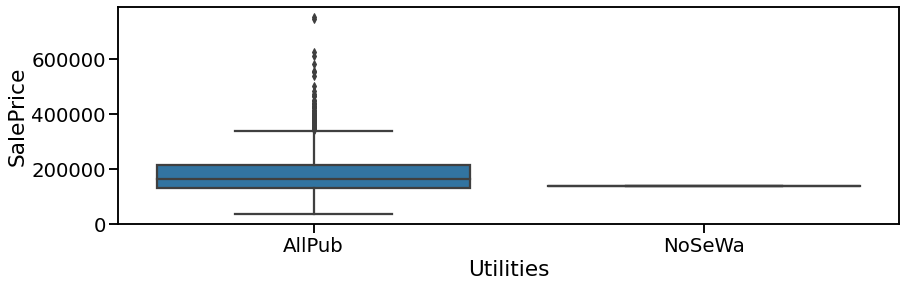

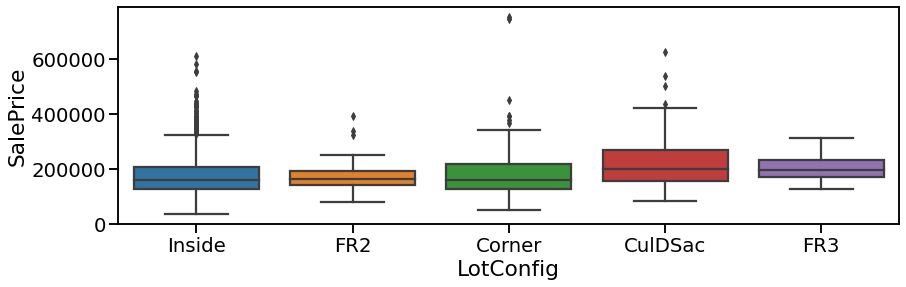

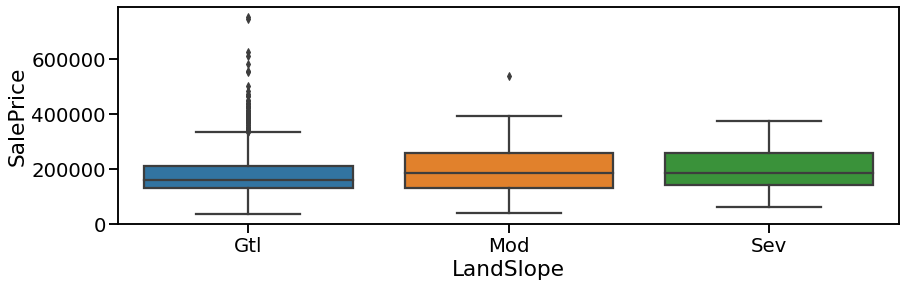

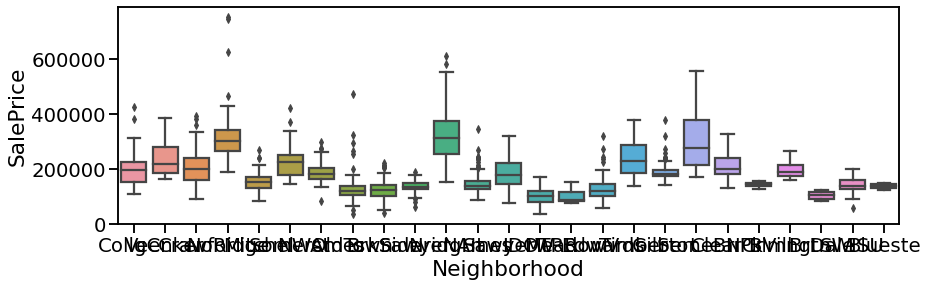

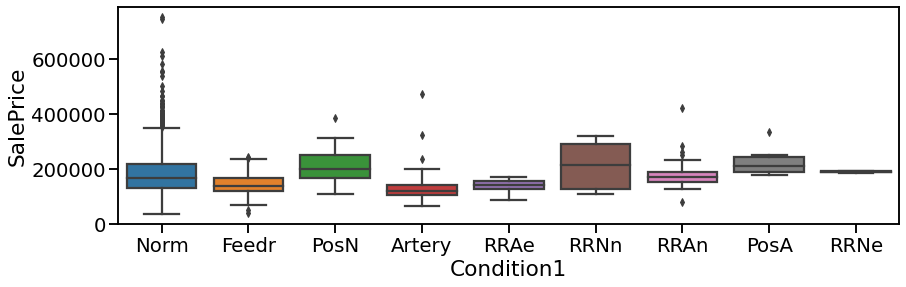

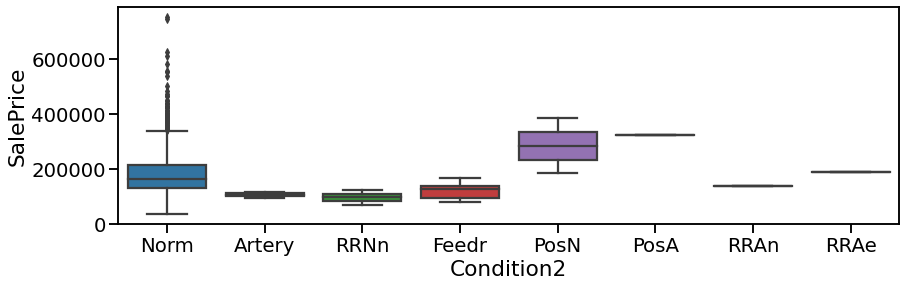

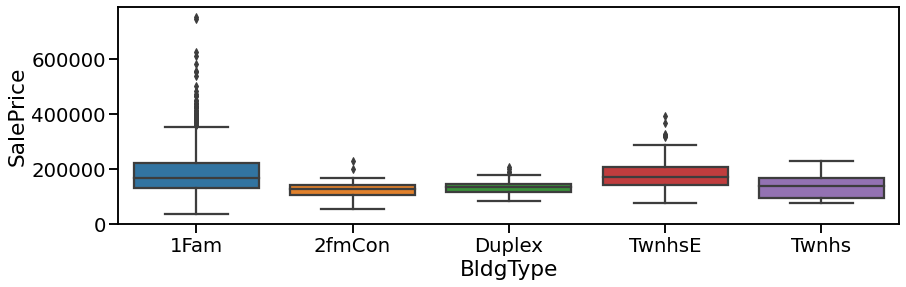

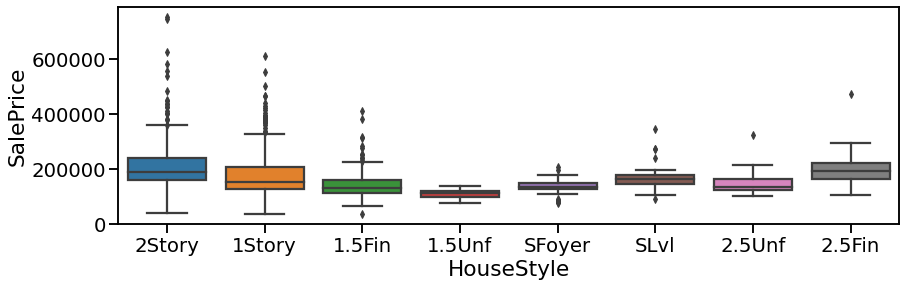

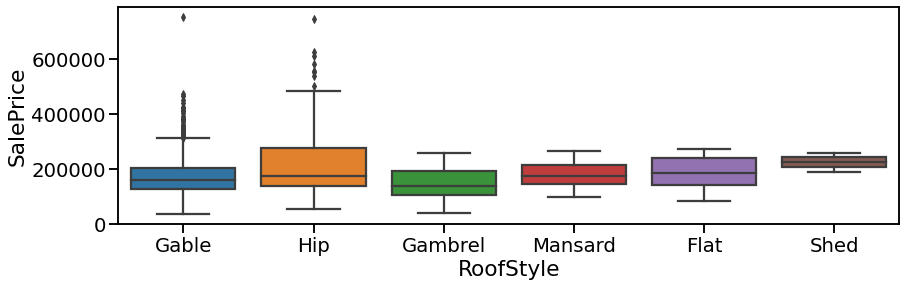

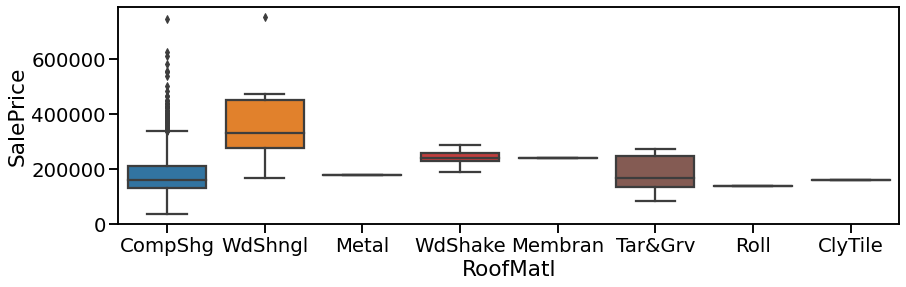

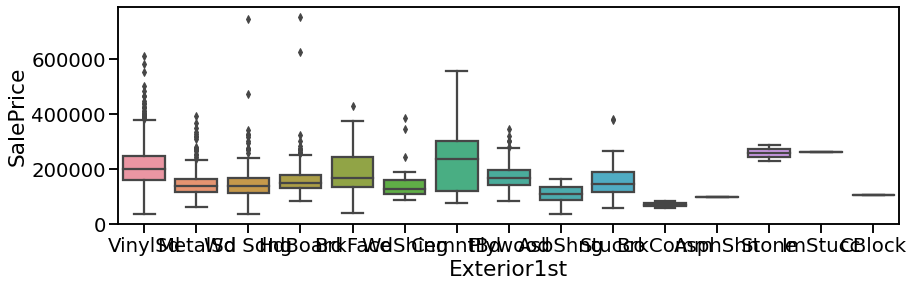

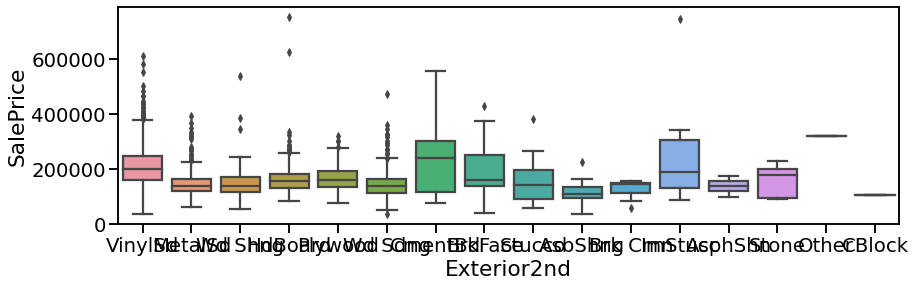

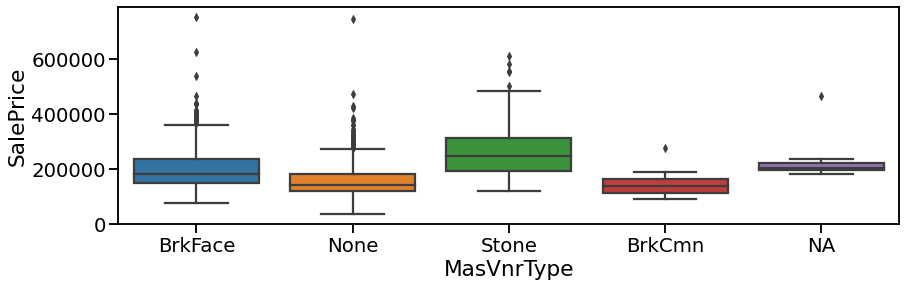

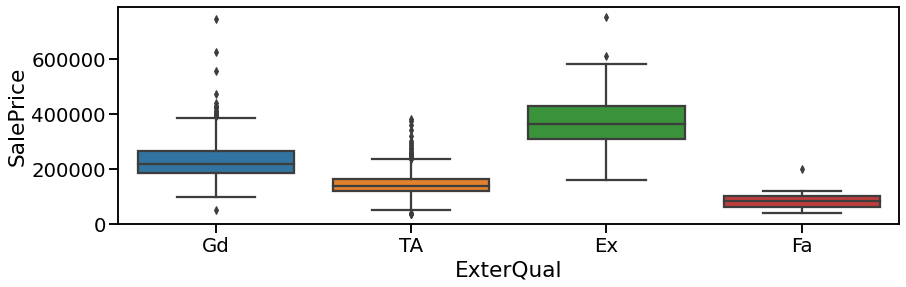

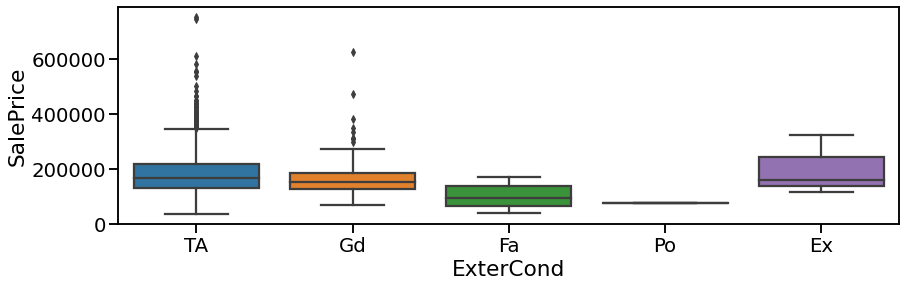

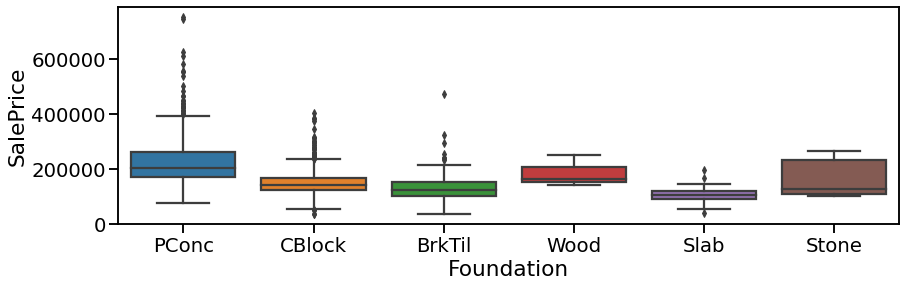

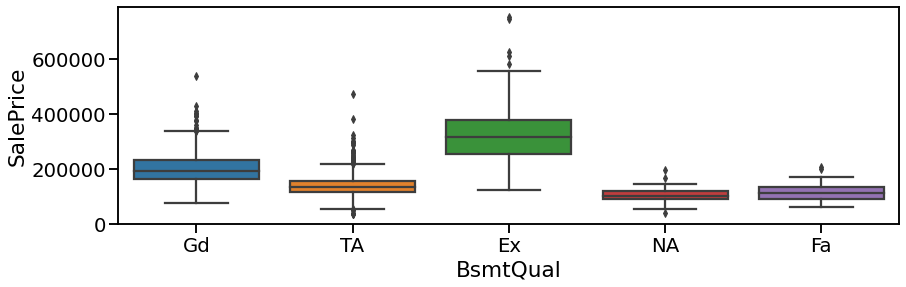

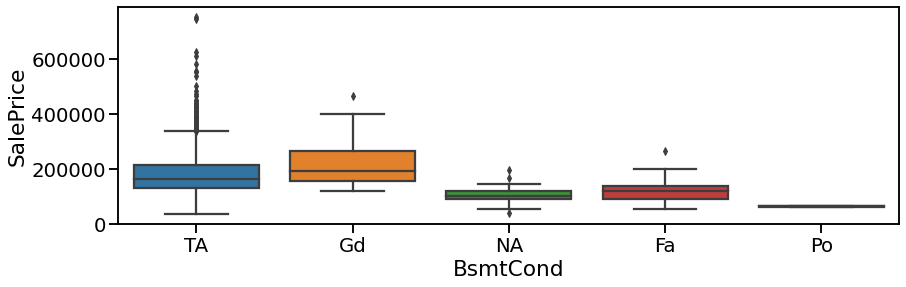

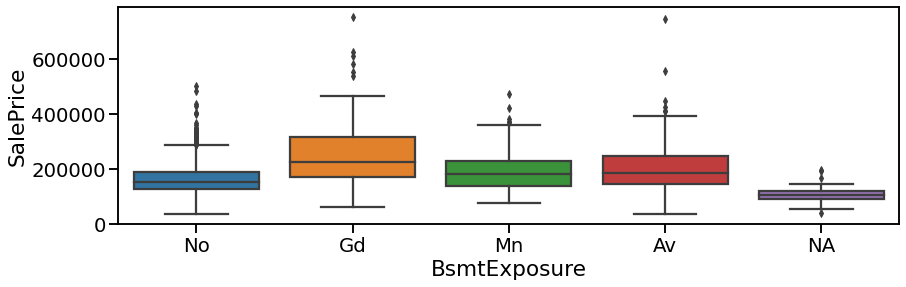

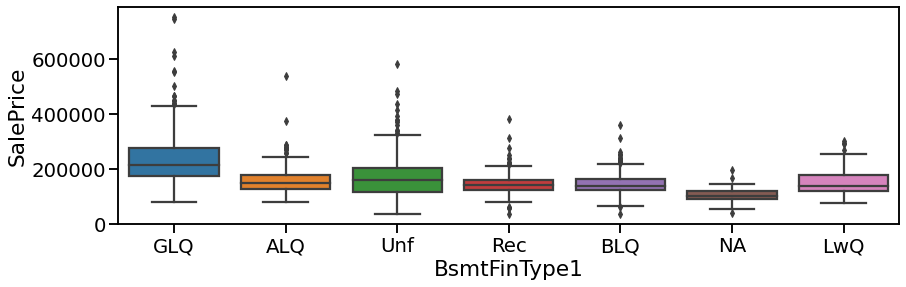

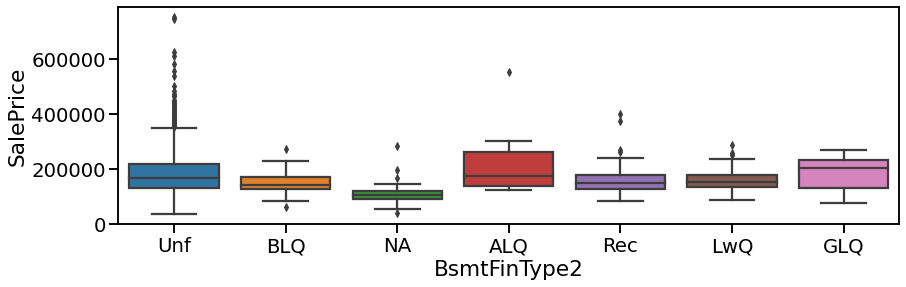

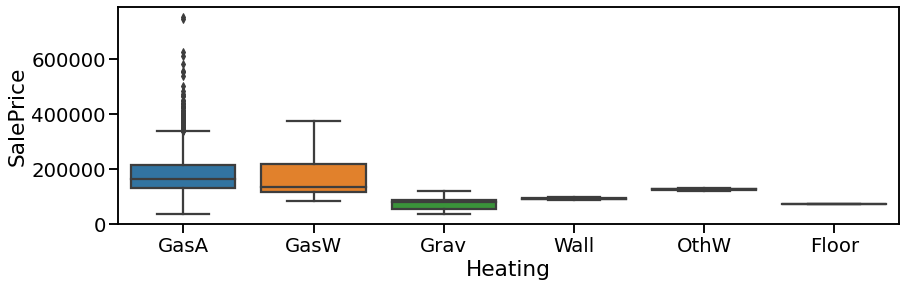

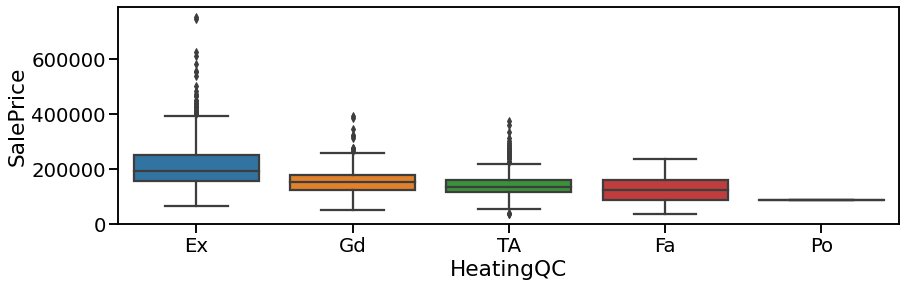

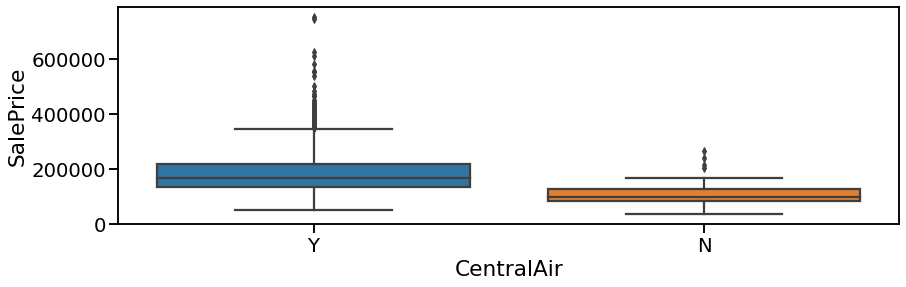

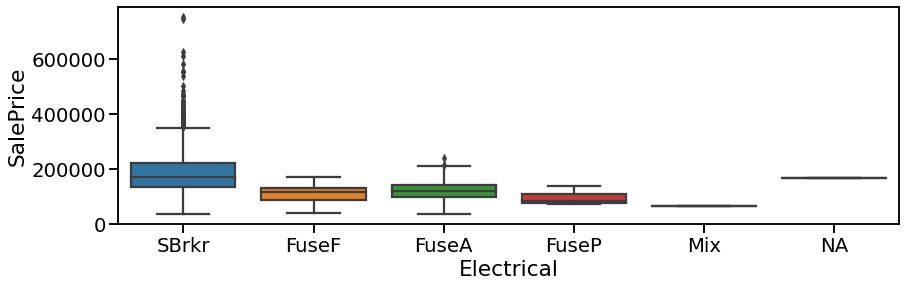

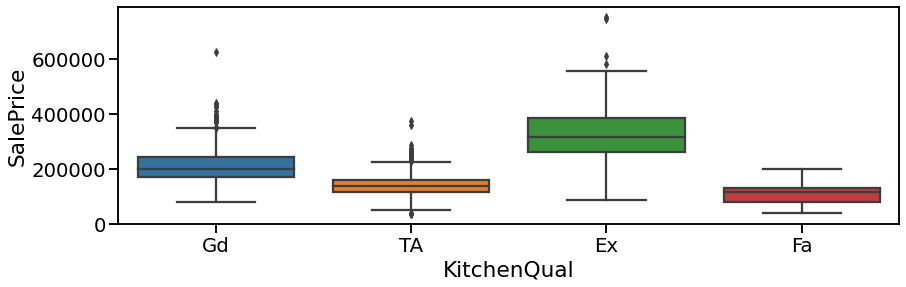

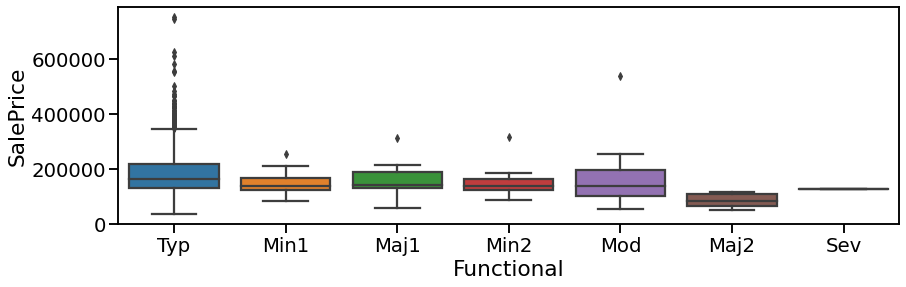

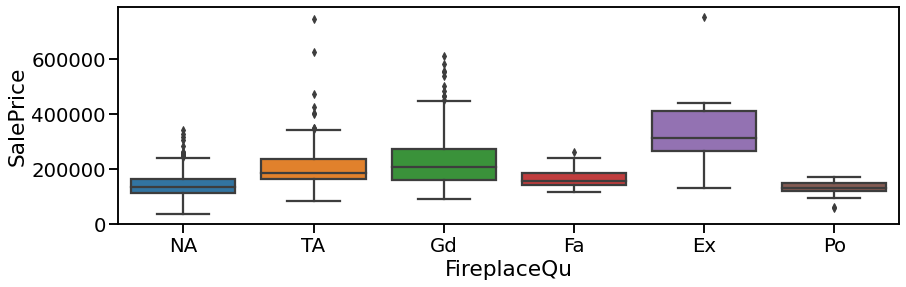

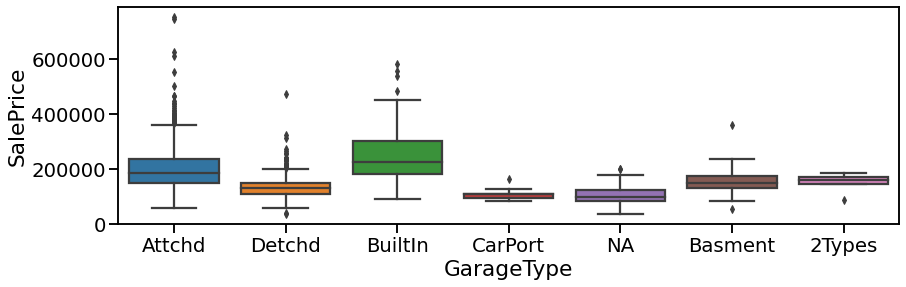

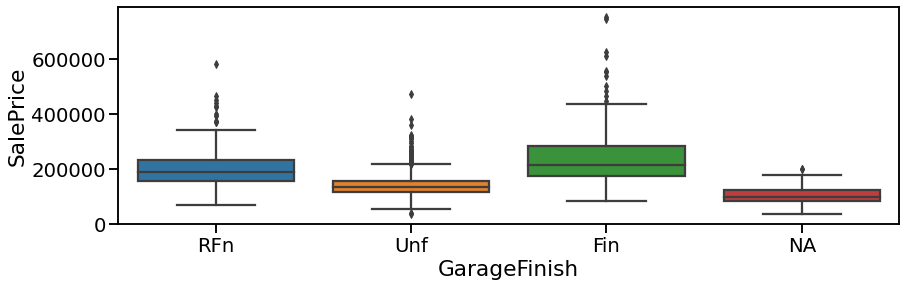

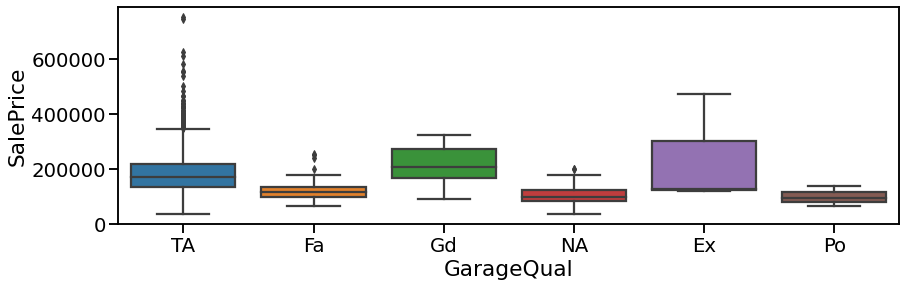

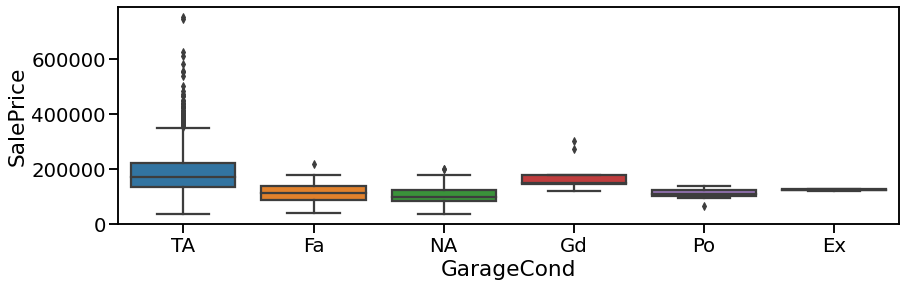

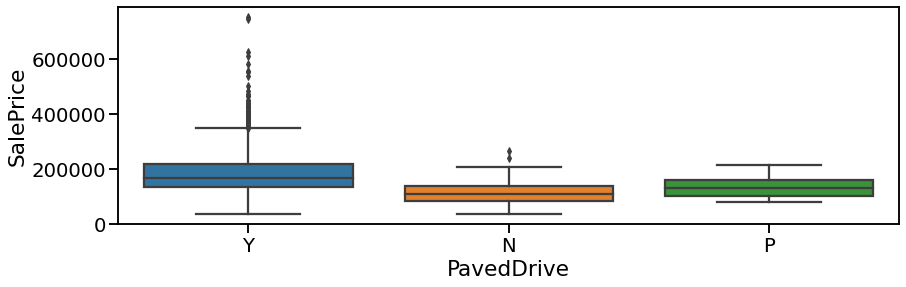

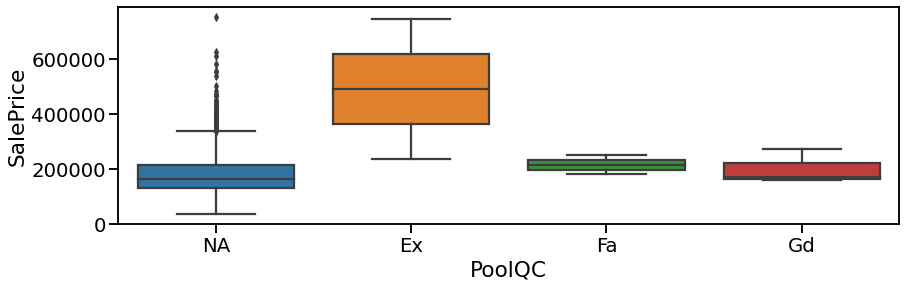

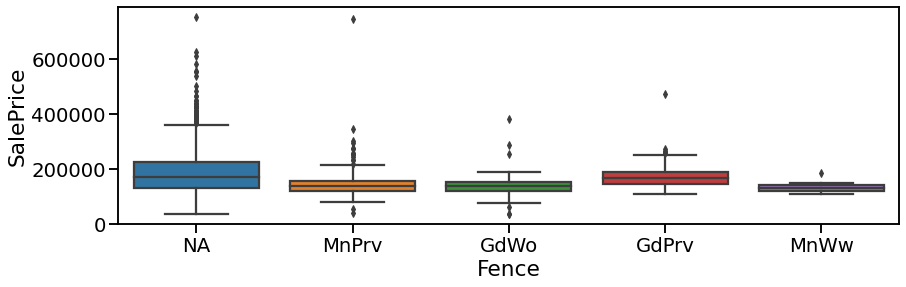

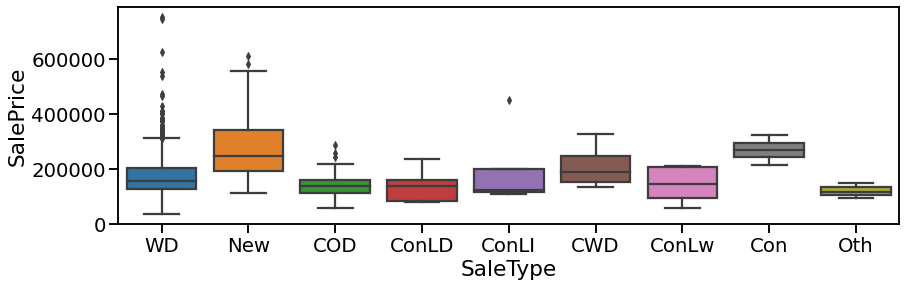

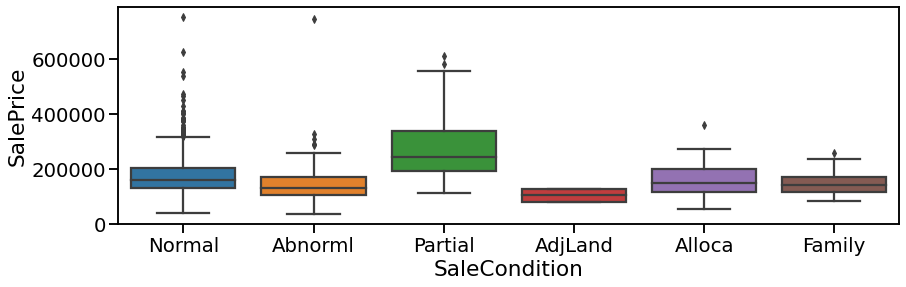

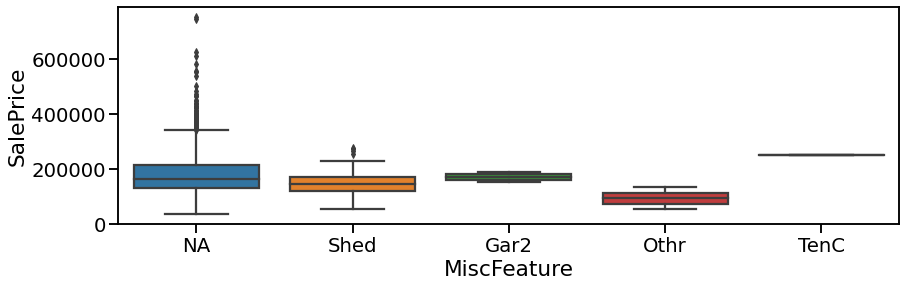

In [41]:
for col in cat_cols:
    fig=plt.figure(figsize=(14, 4))
    sns.boxplot(x=col, y='SalePrice', data=train);

* `CentralAir` is a clear indicator of ihgher sales price
* `MiscFeature` is also for Gar2 ...

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


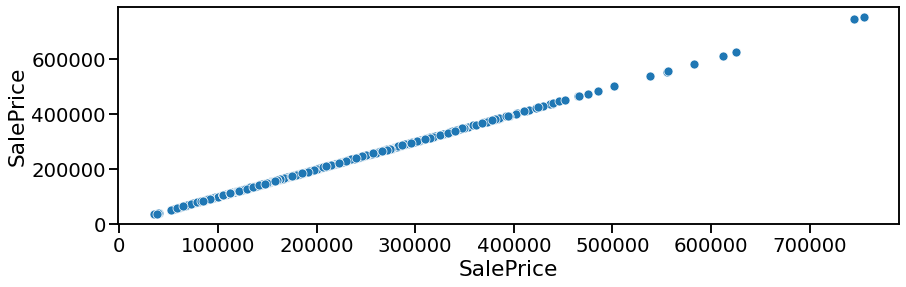

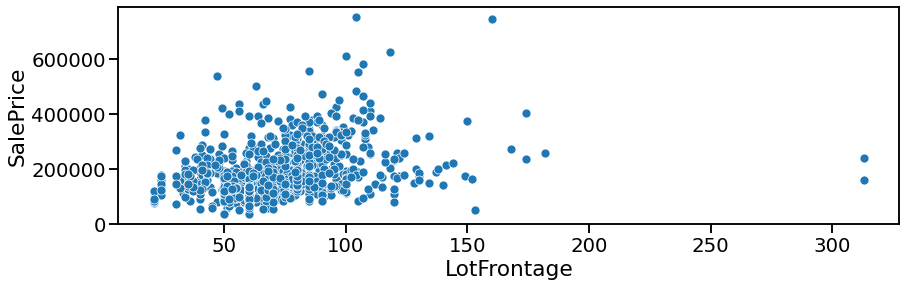

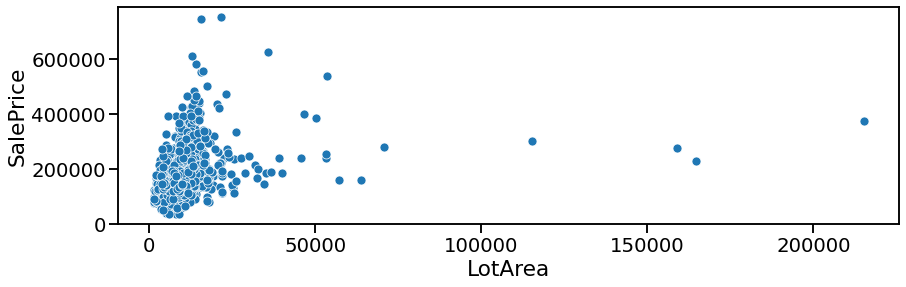

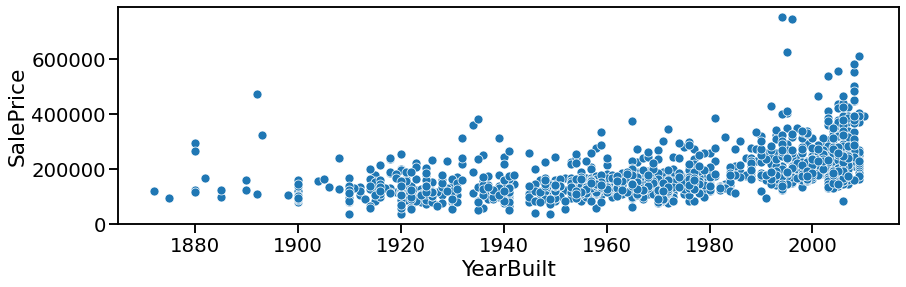

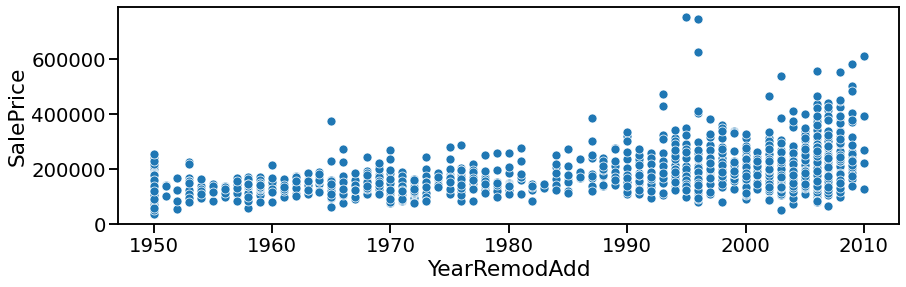

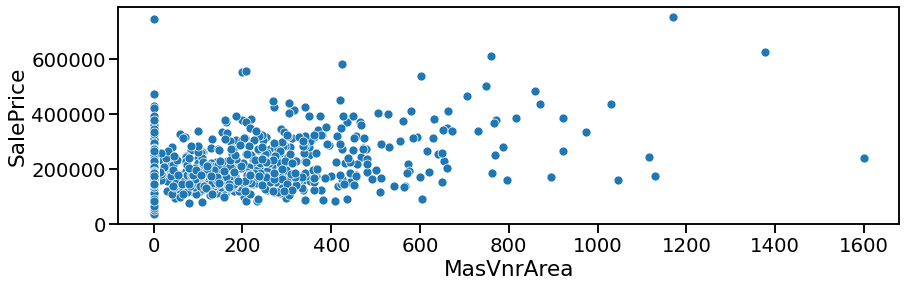

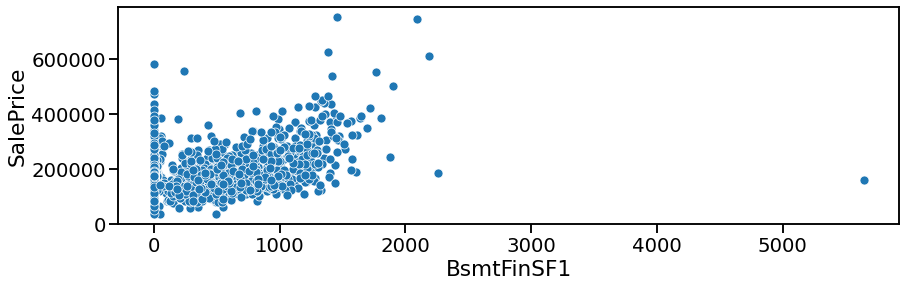

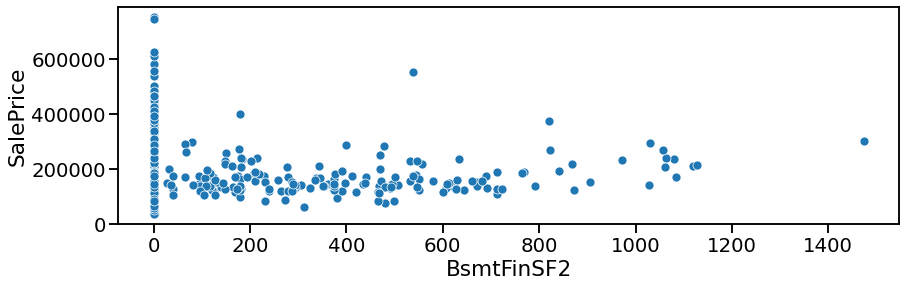

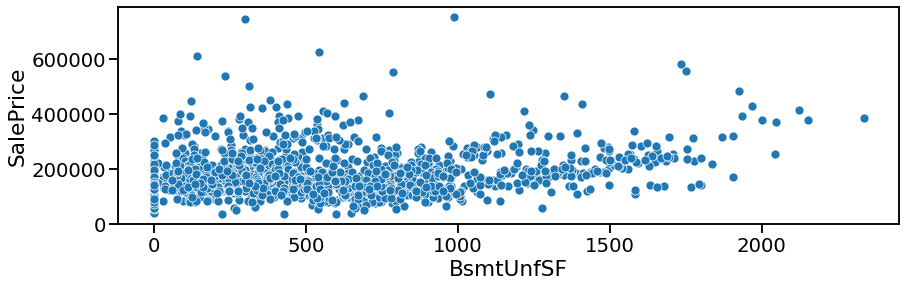

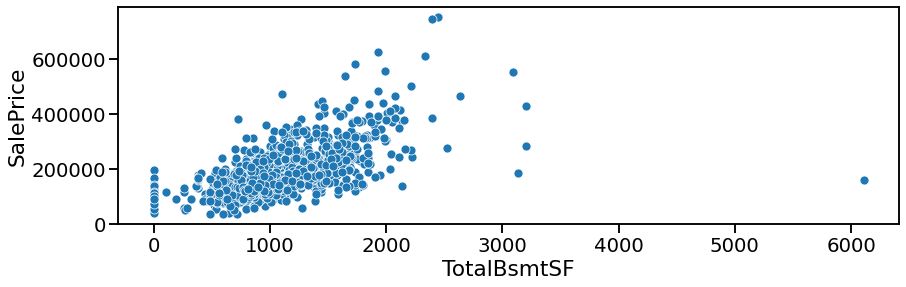

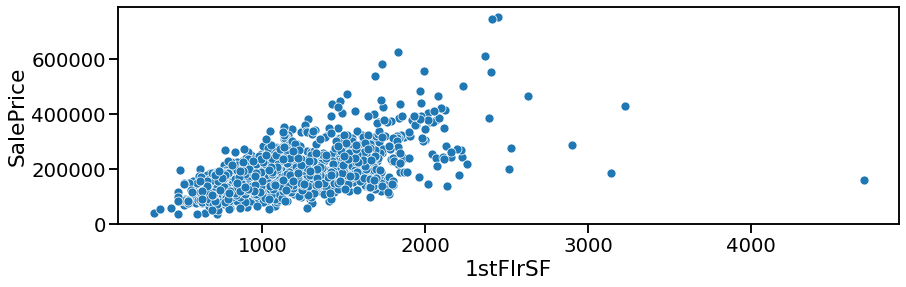

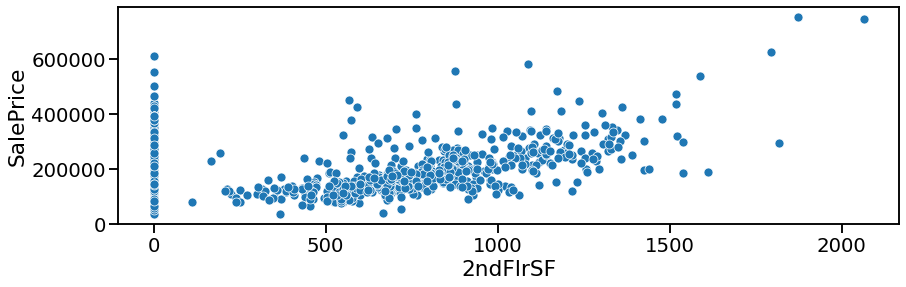

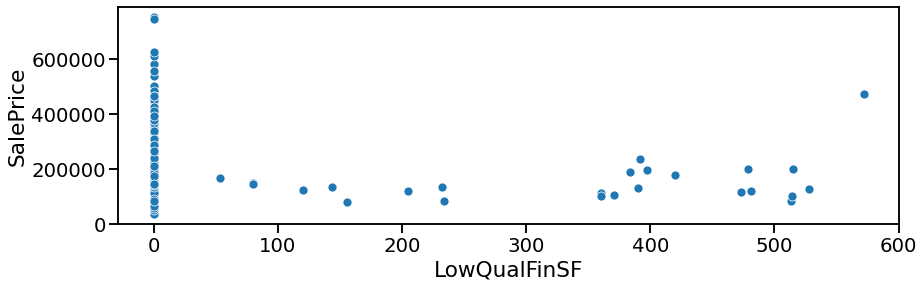

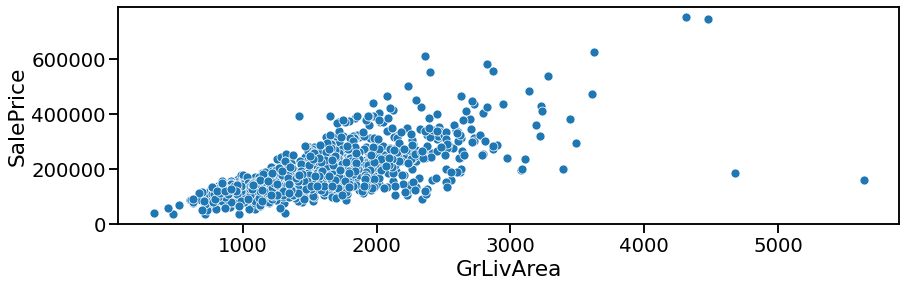

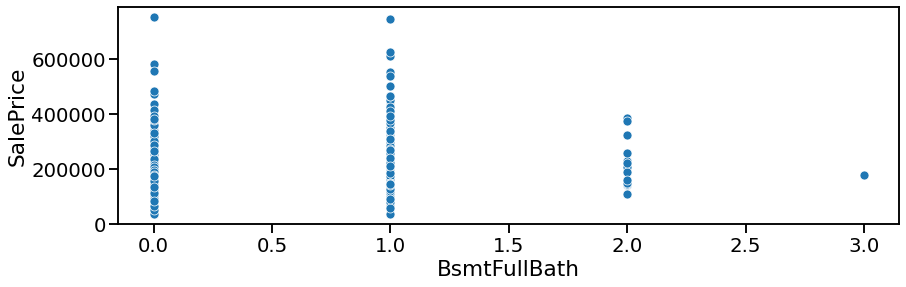

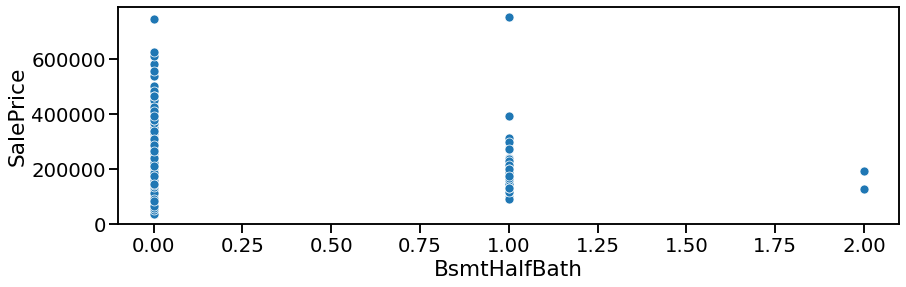

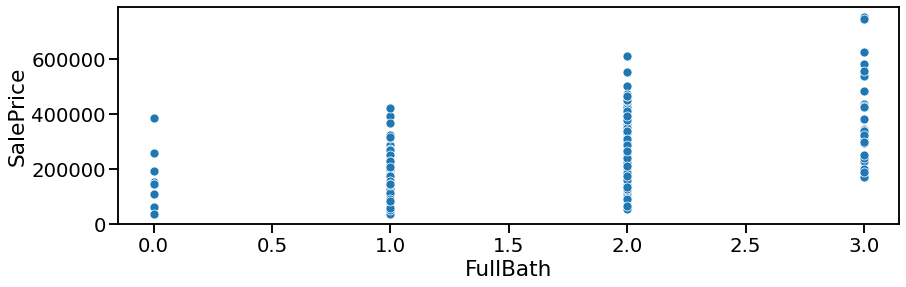

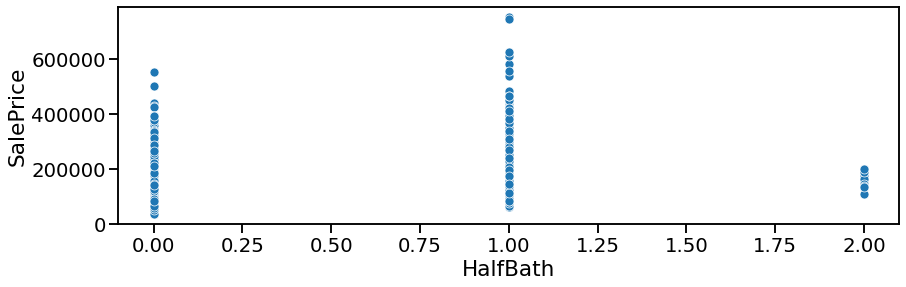

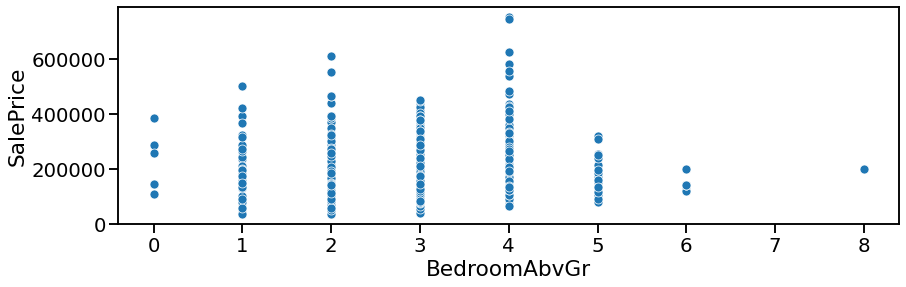

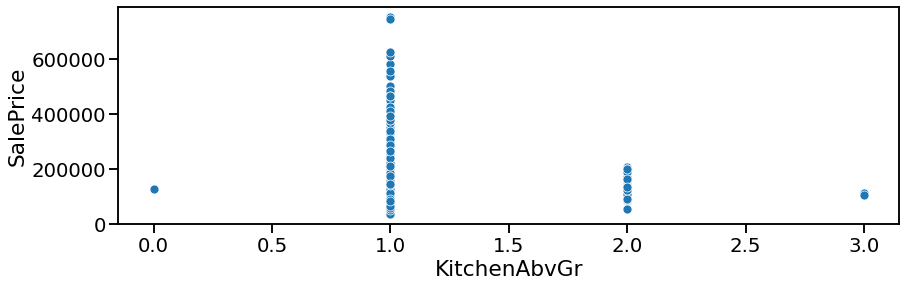

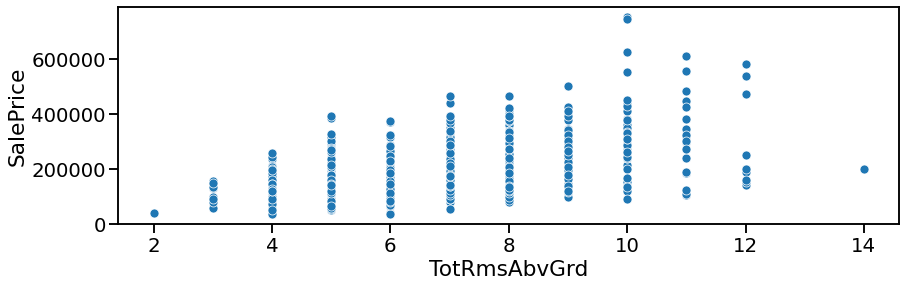

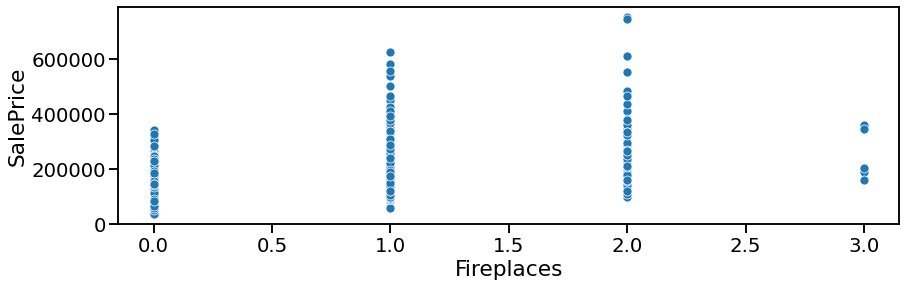

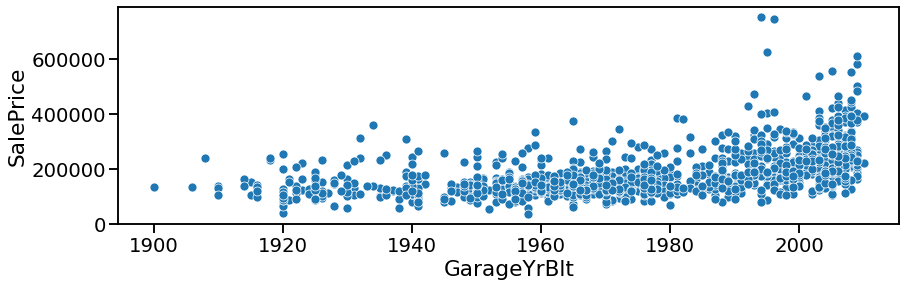

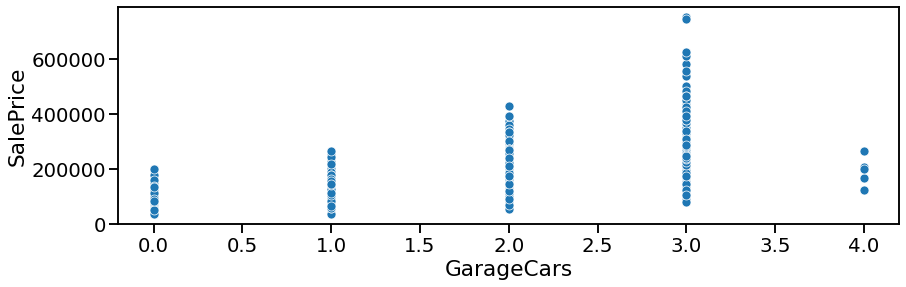

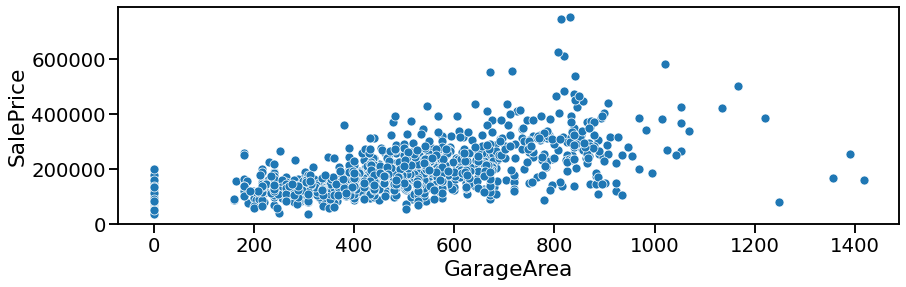

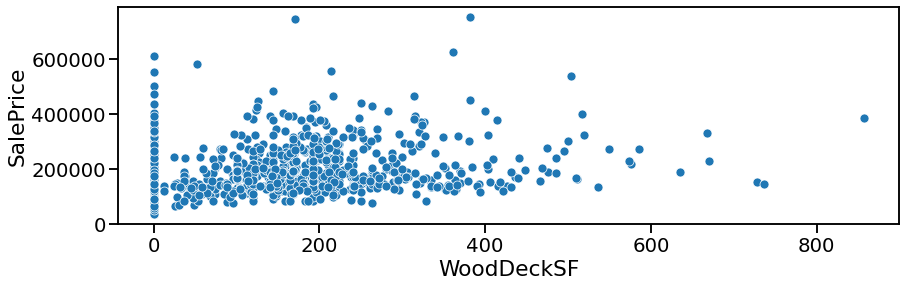

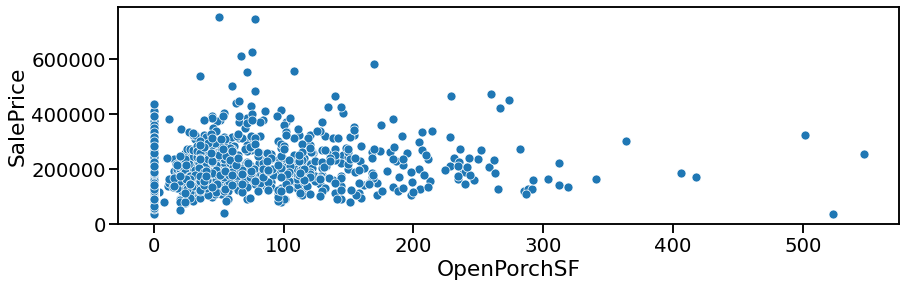

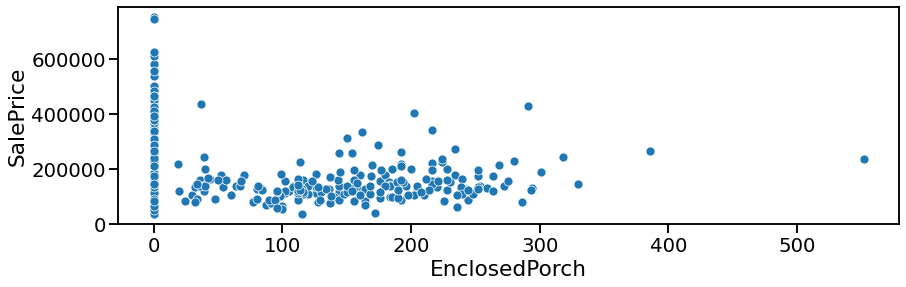

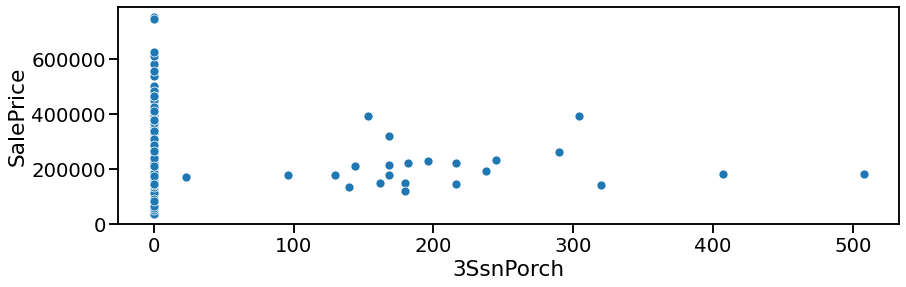

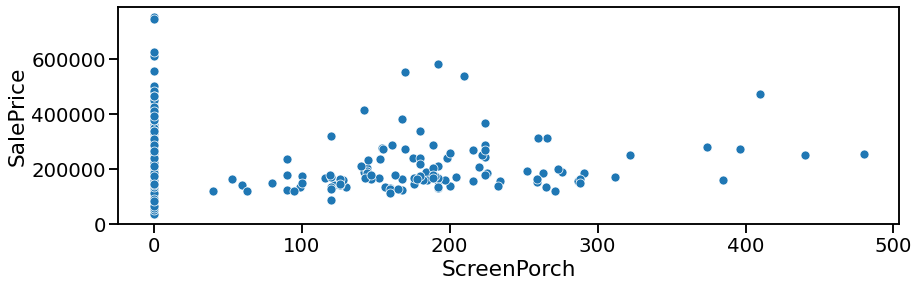

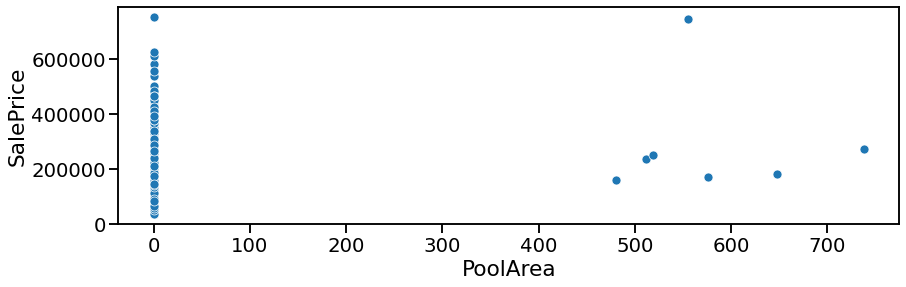

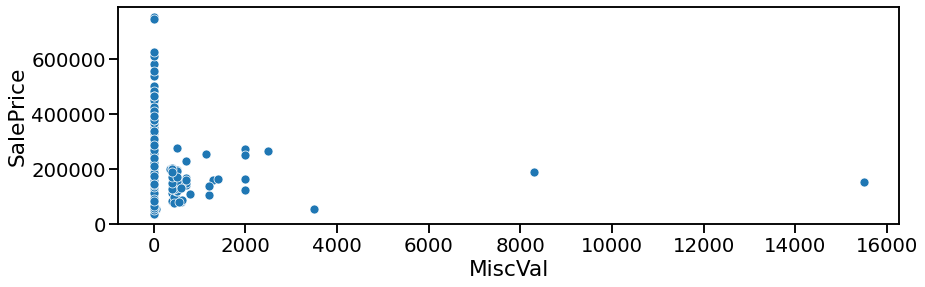

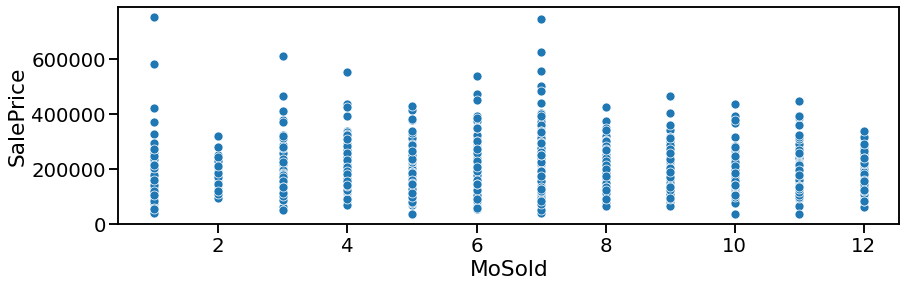

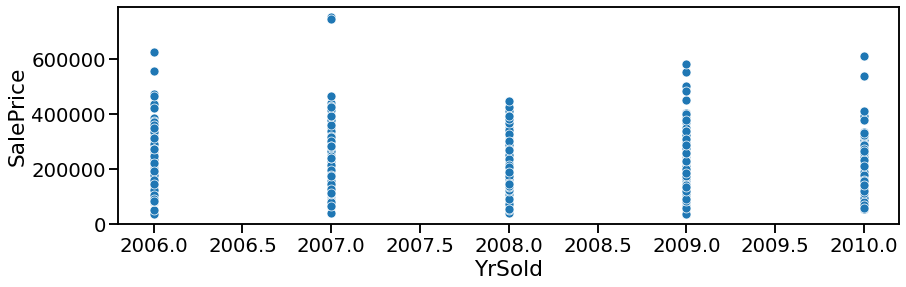

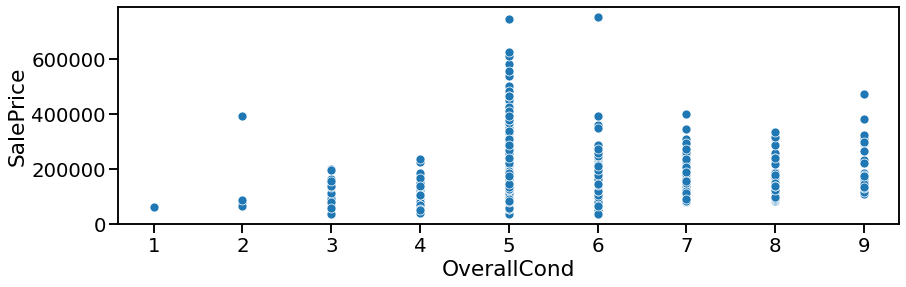

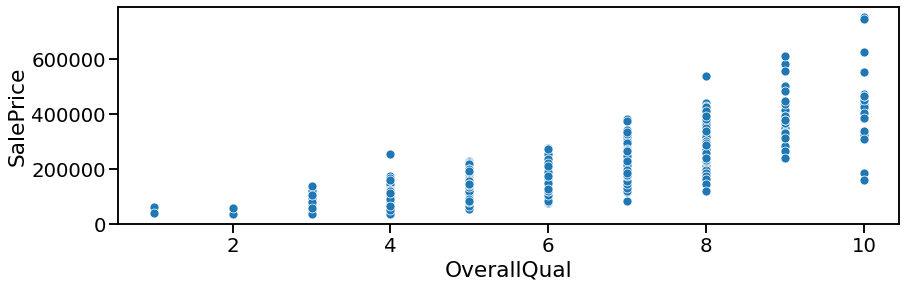

In [42]:
for col in num_cols:
    fig=plt.figure(figsize=(14, 4))
    sns.scatterplot(x=col, y='SalePrice', data=train);

### Sales Price vs Year of Sale

Often house values increase over the years so I test if there is a difference between the sales prices of the 5 years of data:

In [43]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

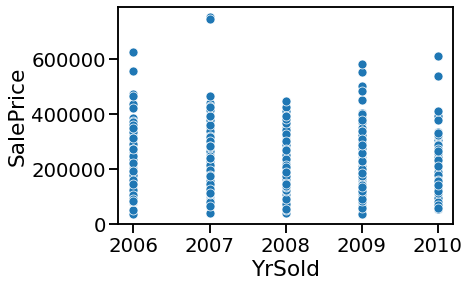

In [44]:
sns.scatterplot(data=train, x='YrSold', y='SalePrice')

In [45]:
train.groupby("YrSold")['SalePrice'].mean()

YrSold
2006    182549.458599
2007    186063.151976
2008    177360.838816
2009    179432.103550
2010    177393.674286
Name: SalePrice, dtype: float64

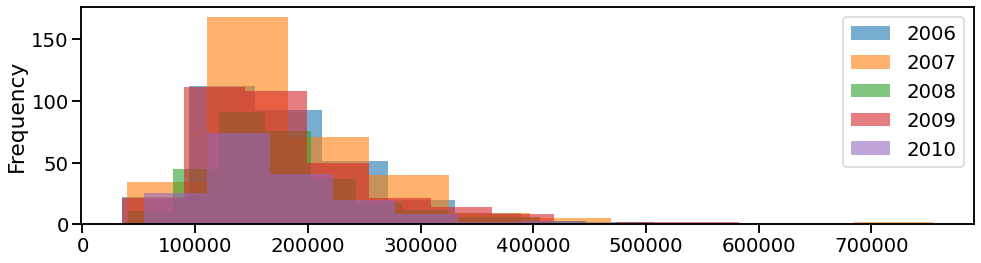

In [46]:
train.groupby("YrSold")['SalePrice'].plot(kind='hist', figsize=(16,4), alpha=0.6)
plt.legend()

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

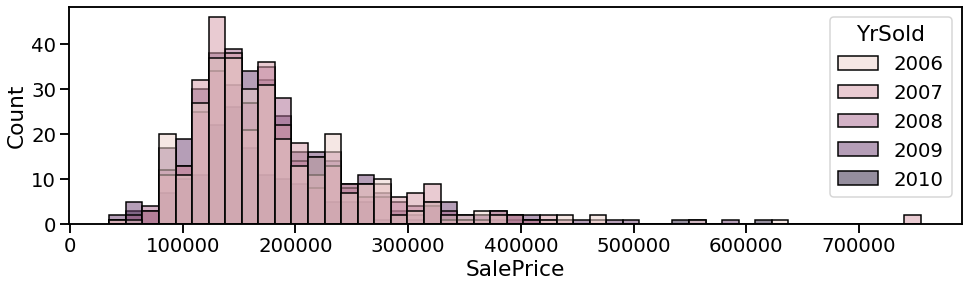

In [47]:
fig, ax= plt.subplots(figsize=(16,4))
sns.histplot(data=train, x='SalePrice', hue='YrSold', ax=ax)


In [48]:
train.groupby("YrSold")['SalePrice'].mean()

YrSold
2006    182549.458599
2007    186063.151976
2008    177360.838816
2009    179432.103550
2010    177393.674286
Name: SalePrice, dtype: float64

In [49]:
train.groupby("YrSold")['SalePrice'].median()

YrSold
2006    163995.0
2007    167000.0
2008    164000.0
2009    162000.0
2010    155000.0
Name: SalePrice, dtype: float64

> Logarithm of SalesPrice also indicates little difference over the years (Metrics).